In [1]:
import json
from pathlib import Path
from functools import partial
from itertools import zip_longest

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, Markdown

In [2]:
SIMILARITIES_PATH_FMT = "../../data/test/user_study/vectors/{model}/similarities_consolidated/validation.similarities.json"
PATH_TO_ARTICLES = "../../data/processed/articles/validation/texts"
PATH_TO_ARTICLE_LABELS = "../../data/processed/articles/validation/labels/labels.json"
PATH_TO_STOCKS = "../../data/processed/stocks/revolut.2021-07-05.complete.stocks.jsonl"
OPTIMAL_RUN_PARAMS = dict(strategy="full", ratio=0.8)

sns.set_style("whitegrid")
color_palette = sns.color_palette("Set2")

In [3]:
def read_all_articles(paths):
    articles = list()
    for path in paths:
        with open(path, "r") as fp:
            article = fp.read()
        articles.append(article)
    return articles


def read_json_file(path):
    with open(path, "r") as fp:
        content = json.load(fp)
    return content

    
def read_json_lines_file(path):
    content = dict()
    with open(path, "r") as fp:
        for line in fp:
            line_content = json.loads(line)
            content[line_content["doc_id"]] = line_content
    return content
    

def get_score(entity_similarities):
    ratio = OPTIMAL_RUN_PARAMS["ratio"]
    strategy = OPTIMAL_RUN_PARAMS["strategy"]
    apply_ratio = lambda x: (ratio) * x + (1 - ratio) * entity_similarities["evs_child"]
    target = "evs_full" if strategy == "full" else "evs_summary"
    score = apply_ratio(entity_similarities[target])
    return score


def print_strong(text):
    markdown = "**" + text + "**"
    display(Markdown(markdown))
    
    
def left_align_text(dataframe):
    return dataframe.style.set_properties(**{'text-align': 'left'})


def tukeys_higher_fence(observations, k=1.75):
    iqr = observations.quantile(0.75) - observations.quantile(0.25)
    return observations.quantile(0.75) + k * iqr


def threshold_func(x):
    return -3/4 * (x-1)**2 + 2

In [4]:
# Specify models
models = ["Doc2Vec(dm-c,d100,n20,w2,mc5,s1e-05,t4,ep40)",
          "Doc2Vec(dm-c,d75,n20,w1,mc5,s1e-05,t4,ep20)",
          "Doc2Vec(dm-c,d50,n20,w2,mc5,s1e-05,t4,ep20)",
          "Doc2Vec(dm-c,d100,n20,w3,mc5,s1e-05,t4,ep40)",
          "Doc2Vec(dm-c,d100,n20,w4,mc5,s1e-05,t4,ep20)"]

model_weights = [1.1, 0.9, 1.2, 0.9, 0.9, 1]

# Specify and read article paths
article_paths = sorted(list(Path(PATH_TO_ARTICLES).glob("*.txt")),
                       key=lambda x: int(x.stem[-1]))
articles = read_all_articles(article_paths)

# Read in labels
labels = read_json_file(PATH_TO_ARTICLE_LABELS)

# Specify similarities generated by the models
similarities = dict.fromkeys(models)
for model in models:
    fmt = dict(model=model)
    similarities[model] = read_json_file(SIMILARITIES_PATH_FMT.format(**fmt))

# Read in stocks
stocks_df = pd.read_json(PATH_TO_STOCKS, lines=True)
stocks_df.drop(columns=["dbpedia_endpoint", "company_name", "wiki_page_id"], inplace=True)

In [5]:
labels['oos_1']

{'title': 'Oil recovers from U.S. inflation-driven plunge',
 'url': 'https://www.reuters.com/business/energy/oil-prices-steady-after-falling-signs-us-may-release-more-reserves-2021-11-11/',
 'type': 'out of sample'}

In [14]:
article_matches = dict()

def show_results(article_id, models=models, stocks_df=stocks_df, articles=articles, max_matches=10):
    print_strong(f"Article {article_id}")
    print(articles[article_id])
    article_labels = labels[list(labels.keys())[article_id]]

    scores_all = None
    for model, weight in zip(models, model_weights):
        # Obtain similarities generated by the model in question
        similarities_ = similarities[model][str(article_id)]
        
        # Obtain similarity scores configured by optimal run params and assign to a column `score`
        _ = {entity:get_score(similarities) for entity, similarities in similarities_.items()}
        scores = pd.Series(data=_, name="score")
        
        if scores_all is None:
            scores_all = scores * weight / len(models)
        else:
            scores_all += scores * weight / len(models)
        
    stocks = stocks_df.copy()
    stocks = stocks.merge(scores_all.to_frame(), left_on="ticker_symbol", right_index=True)

    # Capture distribution parameters
    mean = stocks.score.mean()        
    std = stocks.score.std()
    skewness = stocks.score.skew()
    kurtosis = stocks.score.kurtosis()

    # Find out if outliers exist
#     threshold_for_outliers = tukeys_higher_fence(stocks.score)
#     if any(stocks.score > threshold_for_outliers):
#         threshold = stocks.score.max() - 1.05 * std
#     else:
#         threshold = stocks.score.max() - 0.25 * std

    threshold = stocks.score.max() - threshold_func(skewness) * std

    # Sort `stocks` by `score` and resert index to indicate rankings
    stocks = stocks.sort_values("score", ascending=False).reset_index()

    # Define sets of stocks that were considered relevant by the arbiter but didn't make it
    past_threshold = stocks.score > threshold
    top_tickers = set(stocks[past_threshold].head(max_matches).ticker_symbol) 

    # Display rankings
    with pd.option_context("display.max_colwidth", None):
#         if any(stocks.score > threshold_for_outliers):
#             print(f"{sum(stocks.score > threshold_for_outliers)} outliers detected")
#         else:
#             print("No outliers")

        # Display top rankings as per model
        print_strong("Top stocks")
        display(left_align_text(stocks.copy()[stocks.score > threshold].head(max_matches)))
        article_matches[article_id] = stocks.copy()[stocks.score > threshold].head(max_matches)


    # Display swarmplot and annotate with kurtosis and standard deviation of score distribution
    ax = plt.figure(figsize=(12,4), dpi=200)
    ax = sns.swarmplot(data=stocks[~stocks.ticker_symbol.isin(top_tickers)], x="score", size=7, 
                       color=color_palette[0], alpha=0.9, edgecolor=None)
    ax = sns.swarmplot(data=stocks[stocks.ticker_symbol.isin(top_tickers)], x="score", size=7, 
                       color=color_palette[2], alpha=0.9, edgecolor=None)
    ax.vlines([threshold], 0, 1, transform=ax.get_xaxis_transform(), 
              colors=color_palette[1], lw=1, ls="--")
    ax.set_xticks(np.arange(0.45, 0.8, 0.05))

    ax.annotate("{0:<10}{1:>9.4f}".format("threshold:", threshold), xy=(0.055,0.845), 
                xycoords="figure fraction", fontsize=12)
    ax.annotate("{0:<11}{1:>9.4f}".format("skew:", skewness), xy=(0.055,0.795), 
                xycoords="figure fraction", fontsize=12)
    ax.annotate("{0:<11}{1:>9.4f}".format("kurtosis:", kurtosis), xy=(0.055,0.745), 
                xycoords="figure fraction", fontsize=12)
    ax.annotate("{0:<14}{1:>9.4f}".format("std:", std), xy=(0.055,0.695), 
                xycoords="figure fraction", fontsize=12)
    plt.tight_layout()
    plt.show()

    # Display distribution plot
    ax = plt.figure(figsize=(12,4), dpi=200)
    ax = sns.kdeplot(data=stocks, x="score")
    ax.set_xticks(np.arange(0.45, 0.8, 0.05))
    plt.tight_layout()
    plt.show()

    return stocks

**Article 0**

Bezos’ Blue Origin loses NASA lawsuit over SpaceX $2.9 billion lunar lander contract

KEY POINTS

1. The U.S. Court of Federal Claims ruled against Jeff Bezos’ Blue Origin in the company’s lawsuit against NASA over a $2.9 billion lunar lander contract awarded to SpaceX.
2. Federal judge Richard Hertling sided with the defense in his ruling, completing a months-long battle.
3. A Blue Origin spokesperson said in a statement that the company’s lawsuit “highlighted the important safety issues with the Human Landing System procurement process that must still be addressed.”
4. Musk, in a tweet replying to CNBC’s report on the ruling, posted a photo from the 2012 movie “Dredd.”

The U.S. Court of Federal Claims ruled against Jeff Bezos’ Blue Origin on Thursday in the company’s lawsuit versus NASA over a lucrative astronaut lunar lander contract awarded to Elon Musk’s SpaceX earlier this year.

Federal Judge Richard Hertling sided with the defense in his ruling, completing a monthslong battle 

**Top stocks**

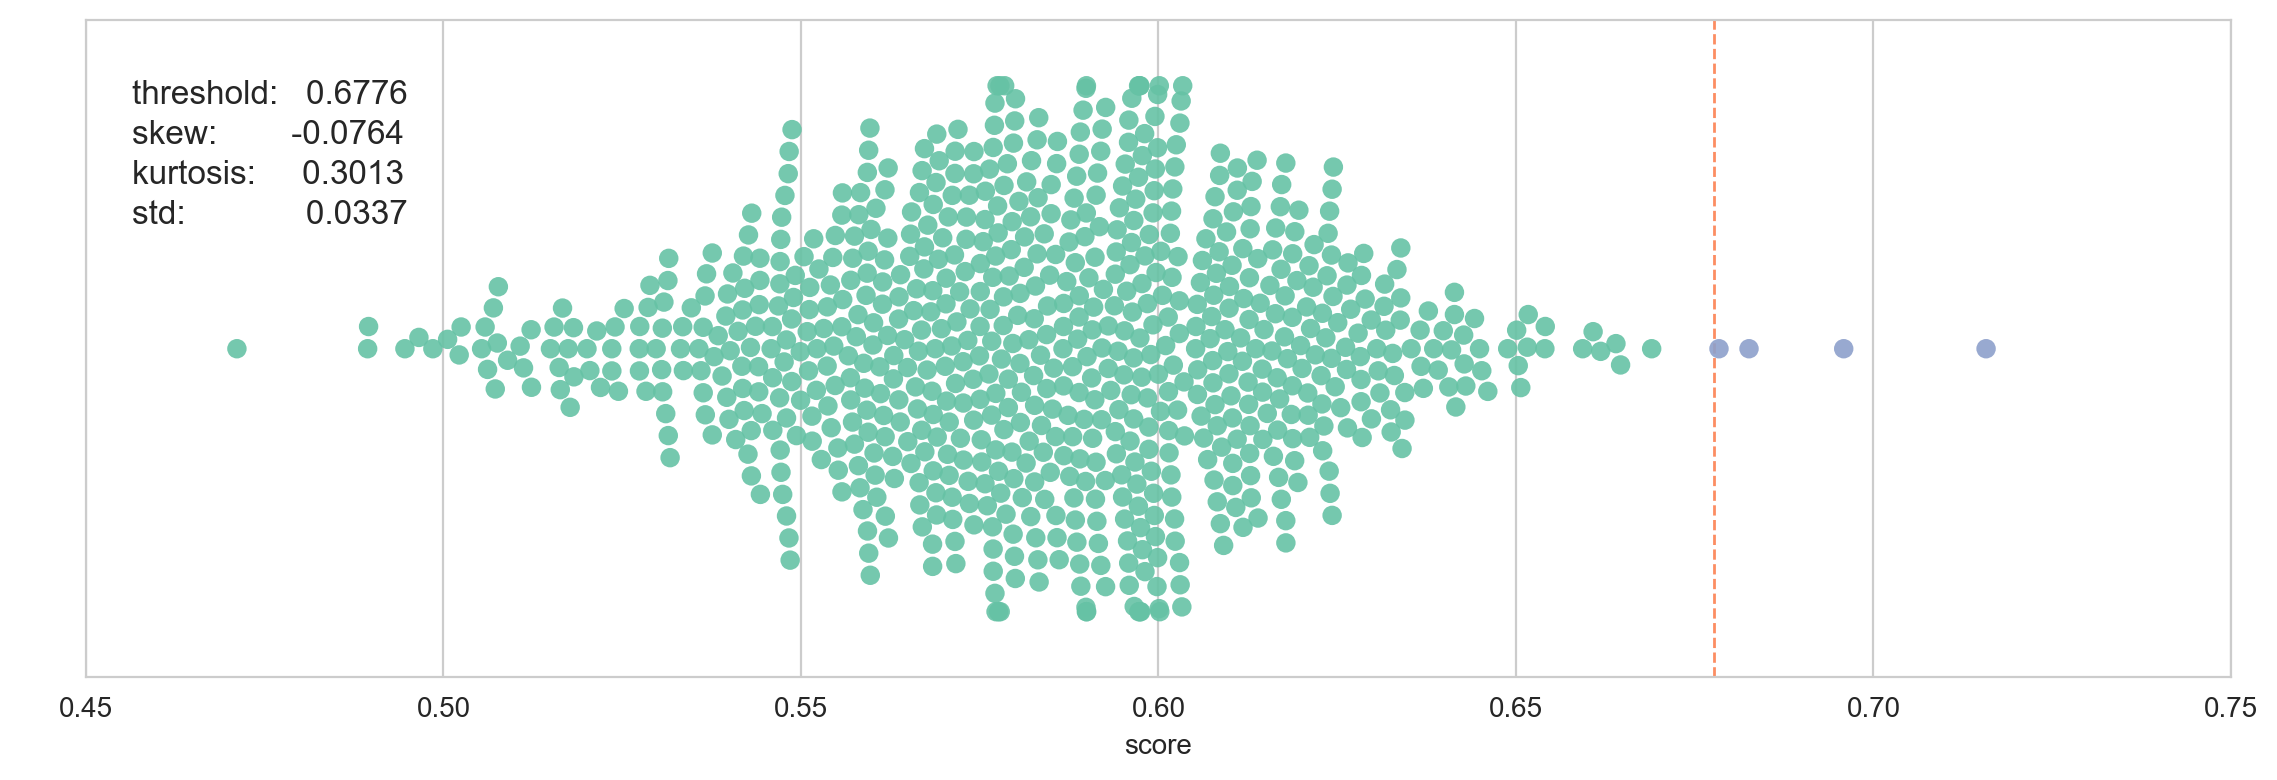

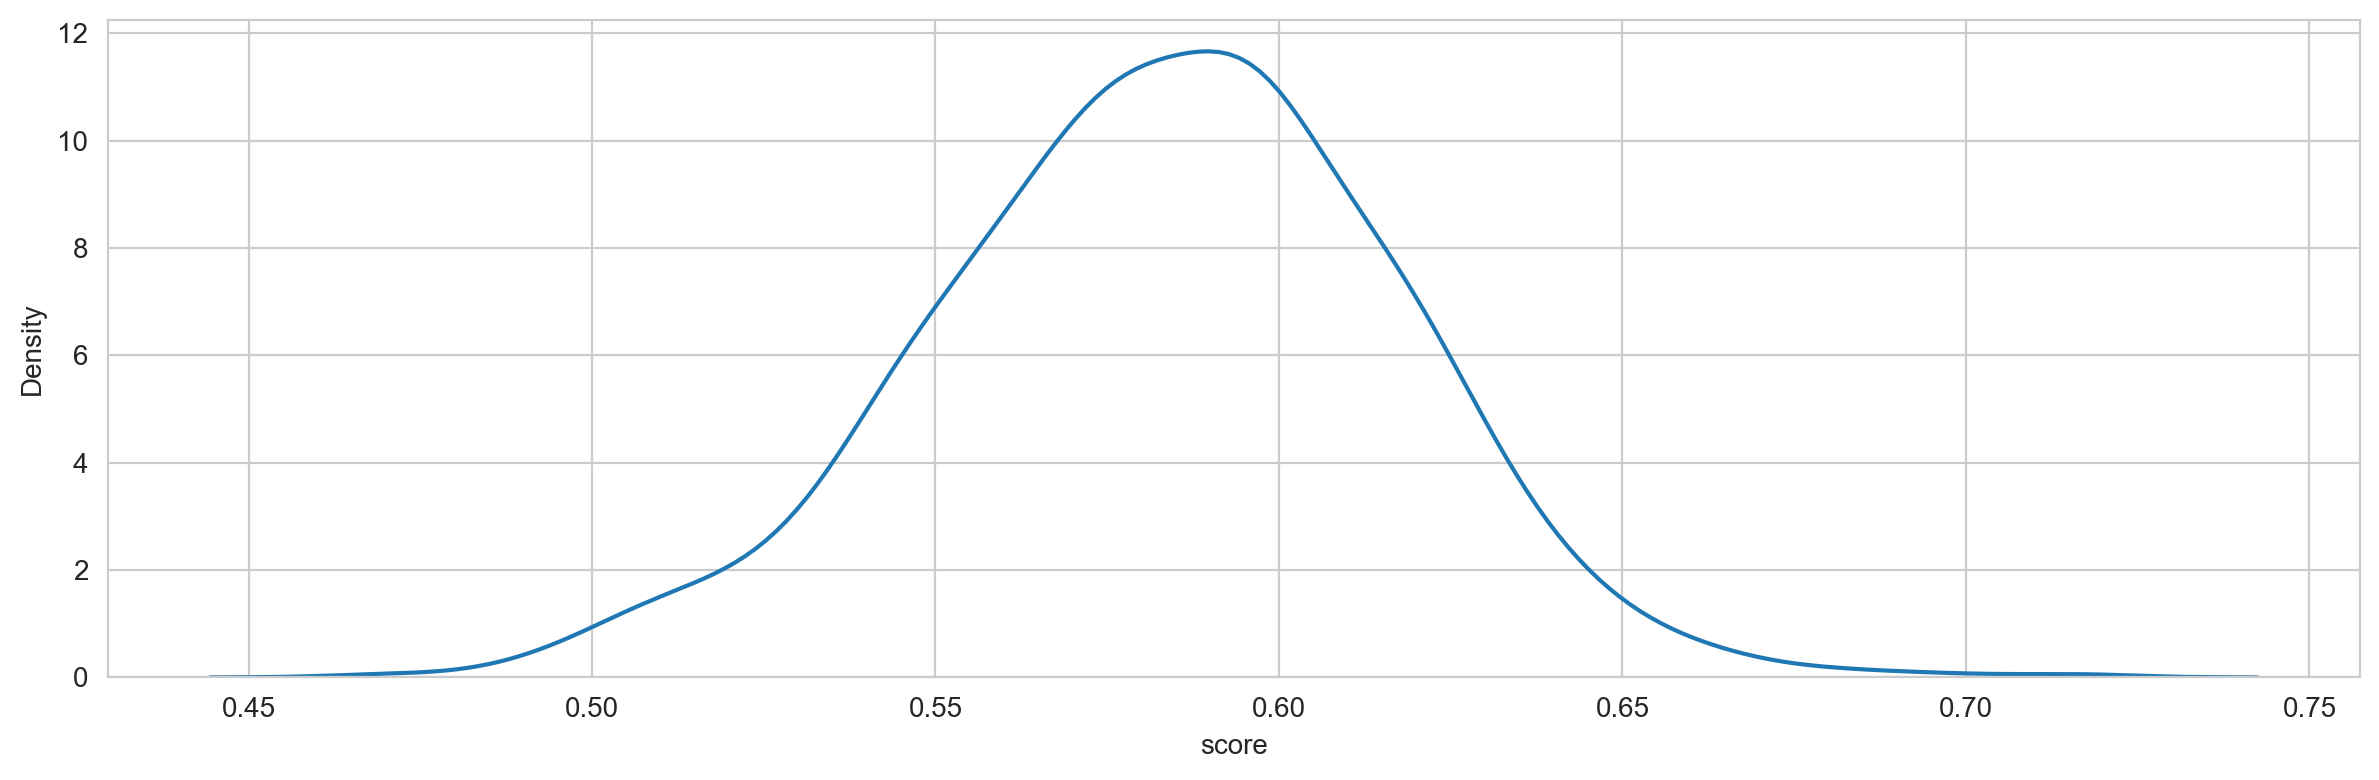

**Article 1**

Oil recovers from U.S. inflation-driven plunge

Summary

1. OPEC lowers oil demand forecast for end of 2021
2. Biden administration could order oil reserves release
3. Brent looks to be consolidating below $85 a barrel -analyst

LONDON, Nov 11 (Reuters) - Oil prices rose above $83 a barrel in volatile trading on Thursday, recovering from sharp falls triggered by concerns over increasing U.S. inflation as OPEC cut its 2021 oil demand forecast due to high energy prices.

Brent crude futures rose 63 cents, or 0.76%, to $83.27 a barrel by 1443 GMT after falling earlier to $81.66. U.S. West Texas Intermediate (WTI) futures were up 63 cents, or 0.77%, at $81.97 after hitting a session low of $80.20.

The Organization of the Petroleum Exporting Countries (OPEC) said in a monthly report it expects oil demand to average 99.49 million barrels per day (bpd) in the fourth quarter of 2021, down 330,000 bpd from last month's forecast. read more

"A slowdown in the pace of recovery in the fourth quar

**Top stocks**

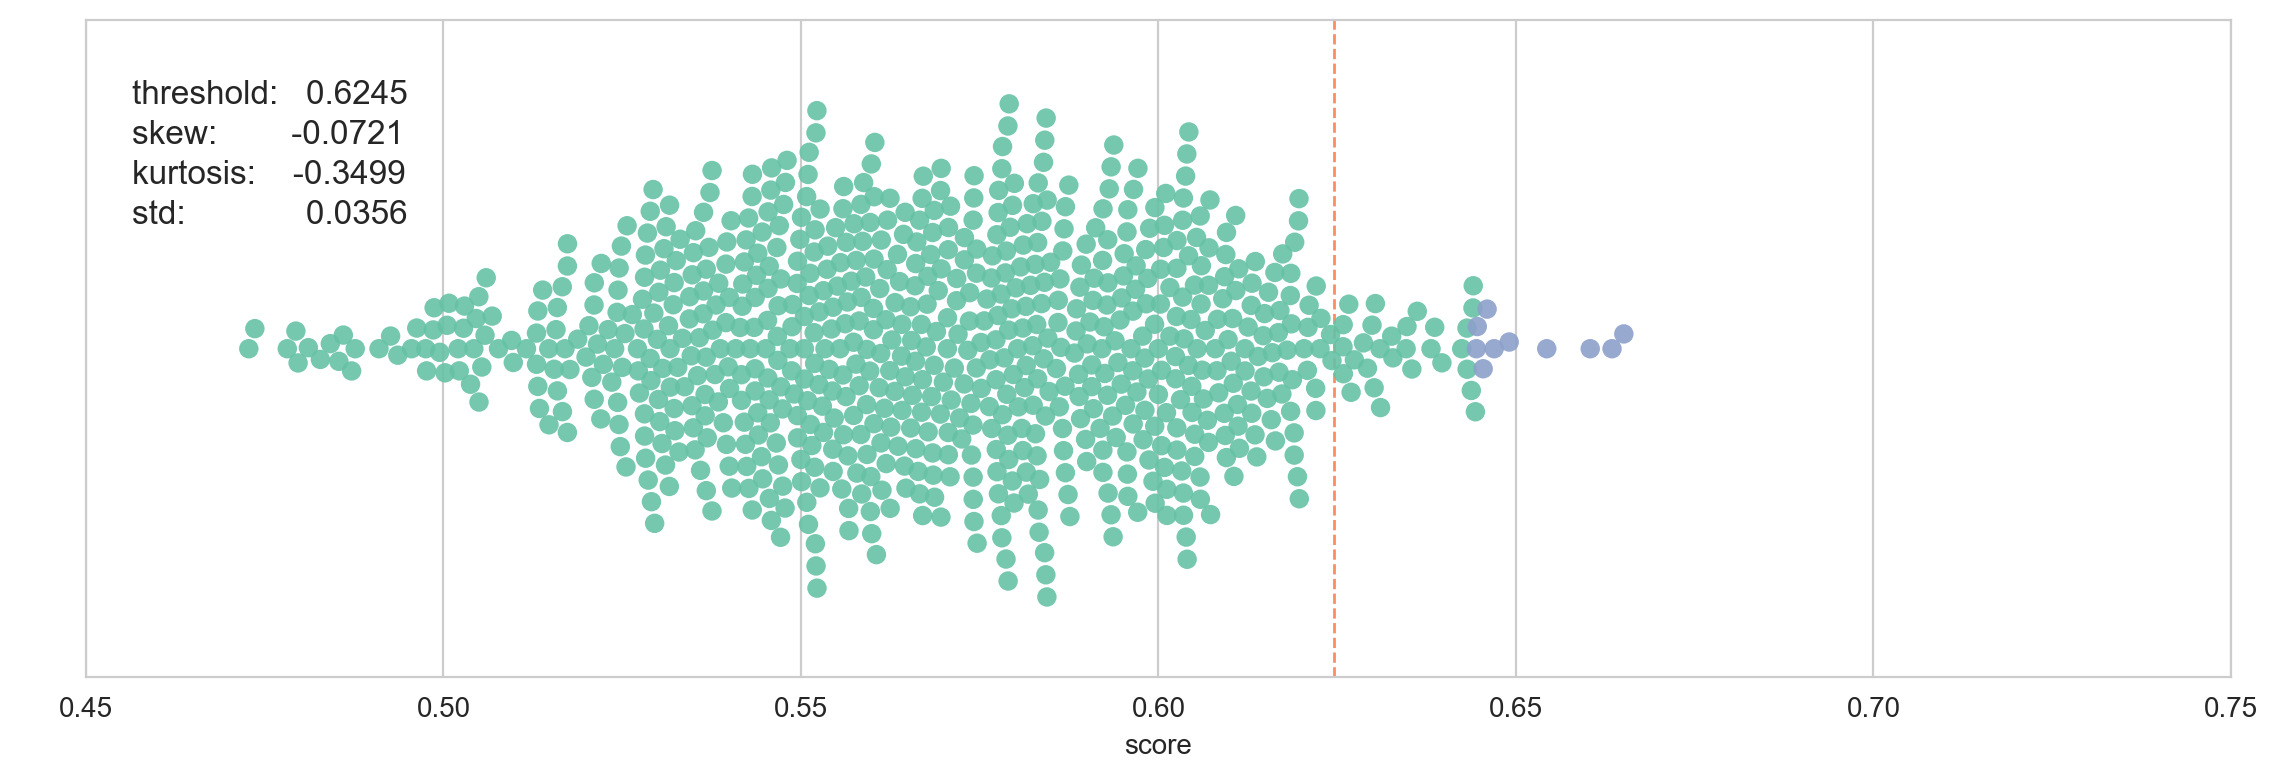

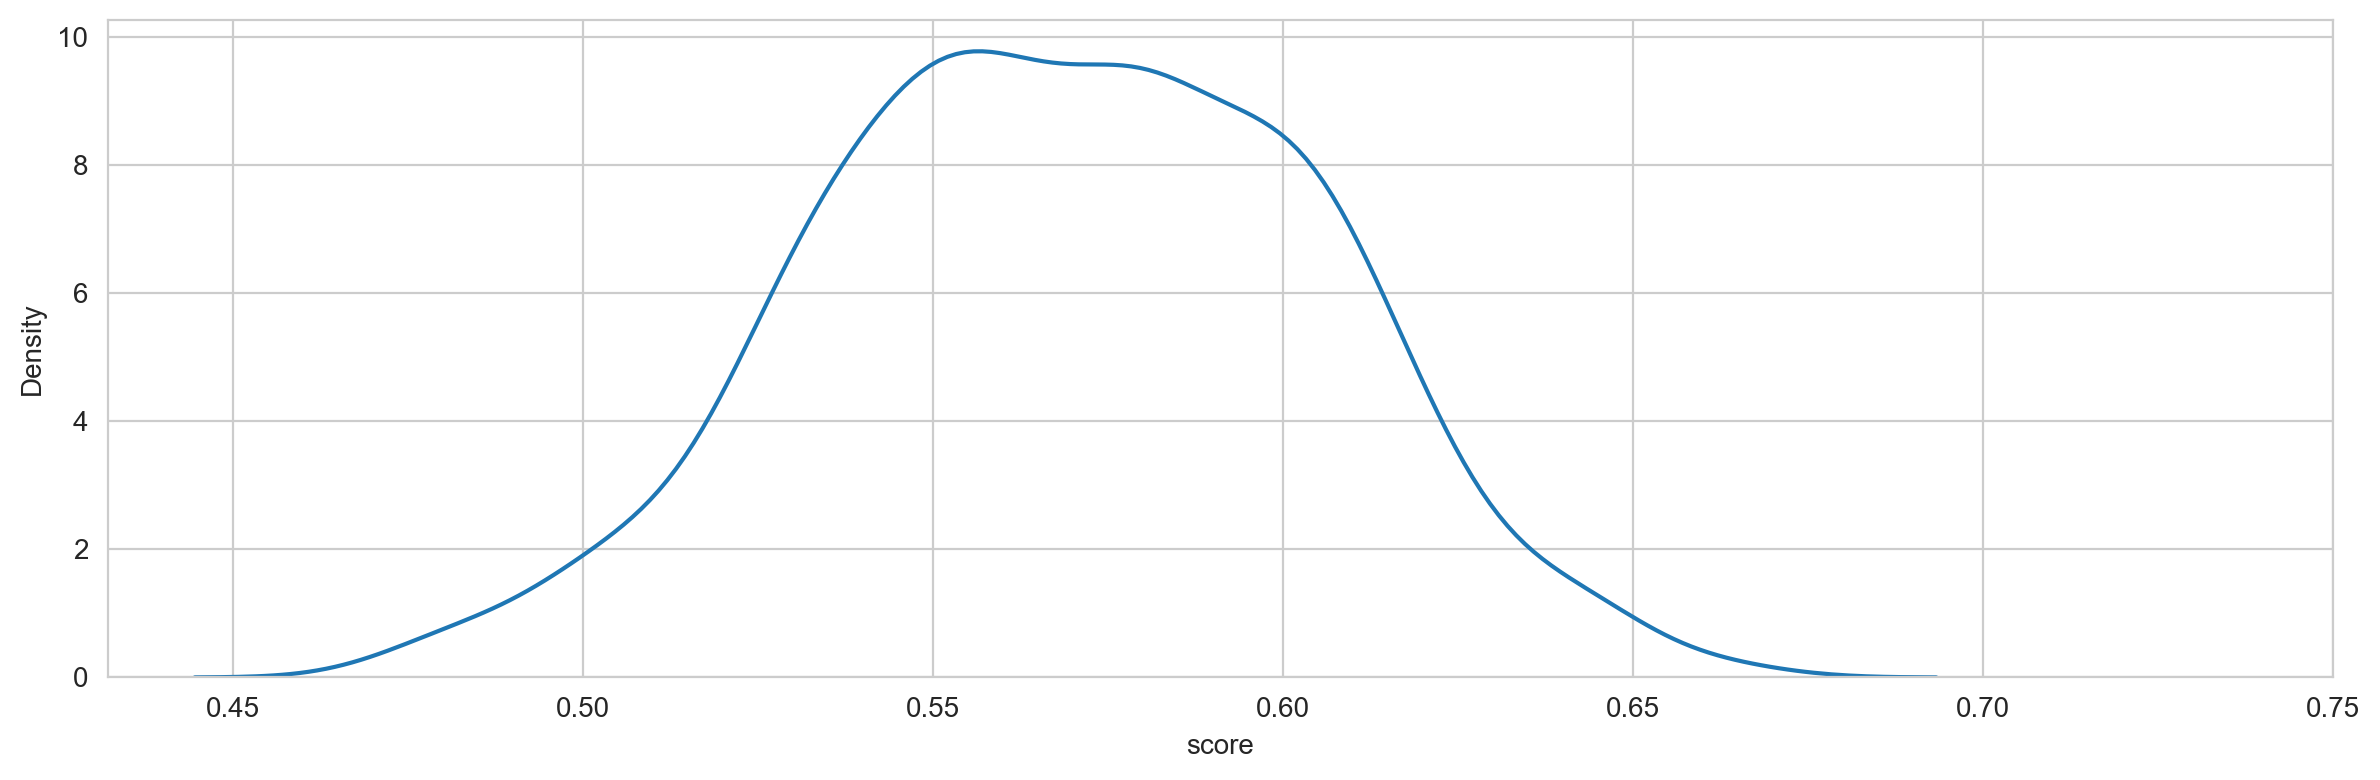

**Article 2**

COP26 Climate Summit in Glasgow: What to Expect

Experts have warned that time is running out to avoid climate catastrophe. Will the global climate conference spark action?

Representatives from countries around the world will gather in Glasgow, Scotland, for the latest round of climate talks—the twenty-sixth Conference of the Parties (COP26)—during the first two weeks of November.

What’s at stake?

Scientists and UN officials have warned that if governments don’t take drastic action to reduce emissions immediately, much of the world will suffer climate catastrophes, such as devastating sea-level rise, longer and more intense heat waves, and widespread species loss, among other consequences. 

The Paris accord aims to keep the global average temperature from rising by 1.5°C (2.7°F) above preindustrial levels and, failing that, prevent it from reaching 2°C (3.6°F) above. But the world has already warmed 1.1°C, and a UN assessment [PDF] released in August predicted that warming will exc

**Top stocks**

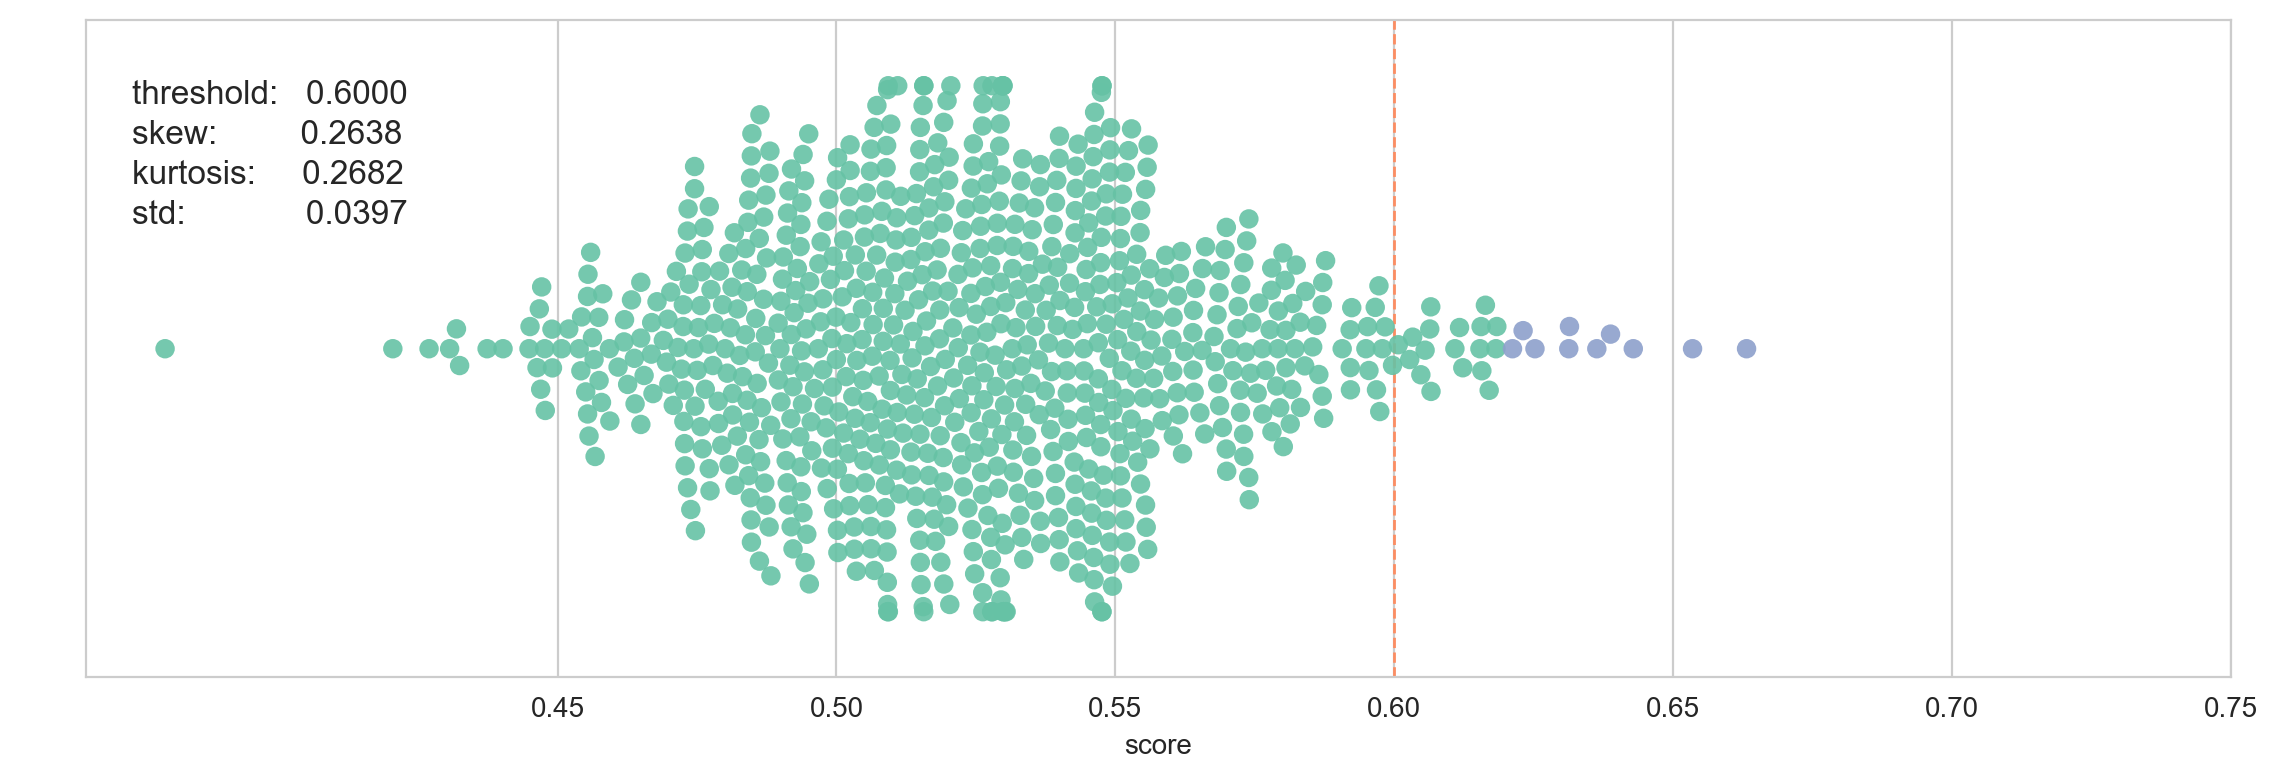

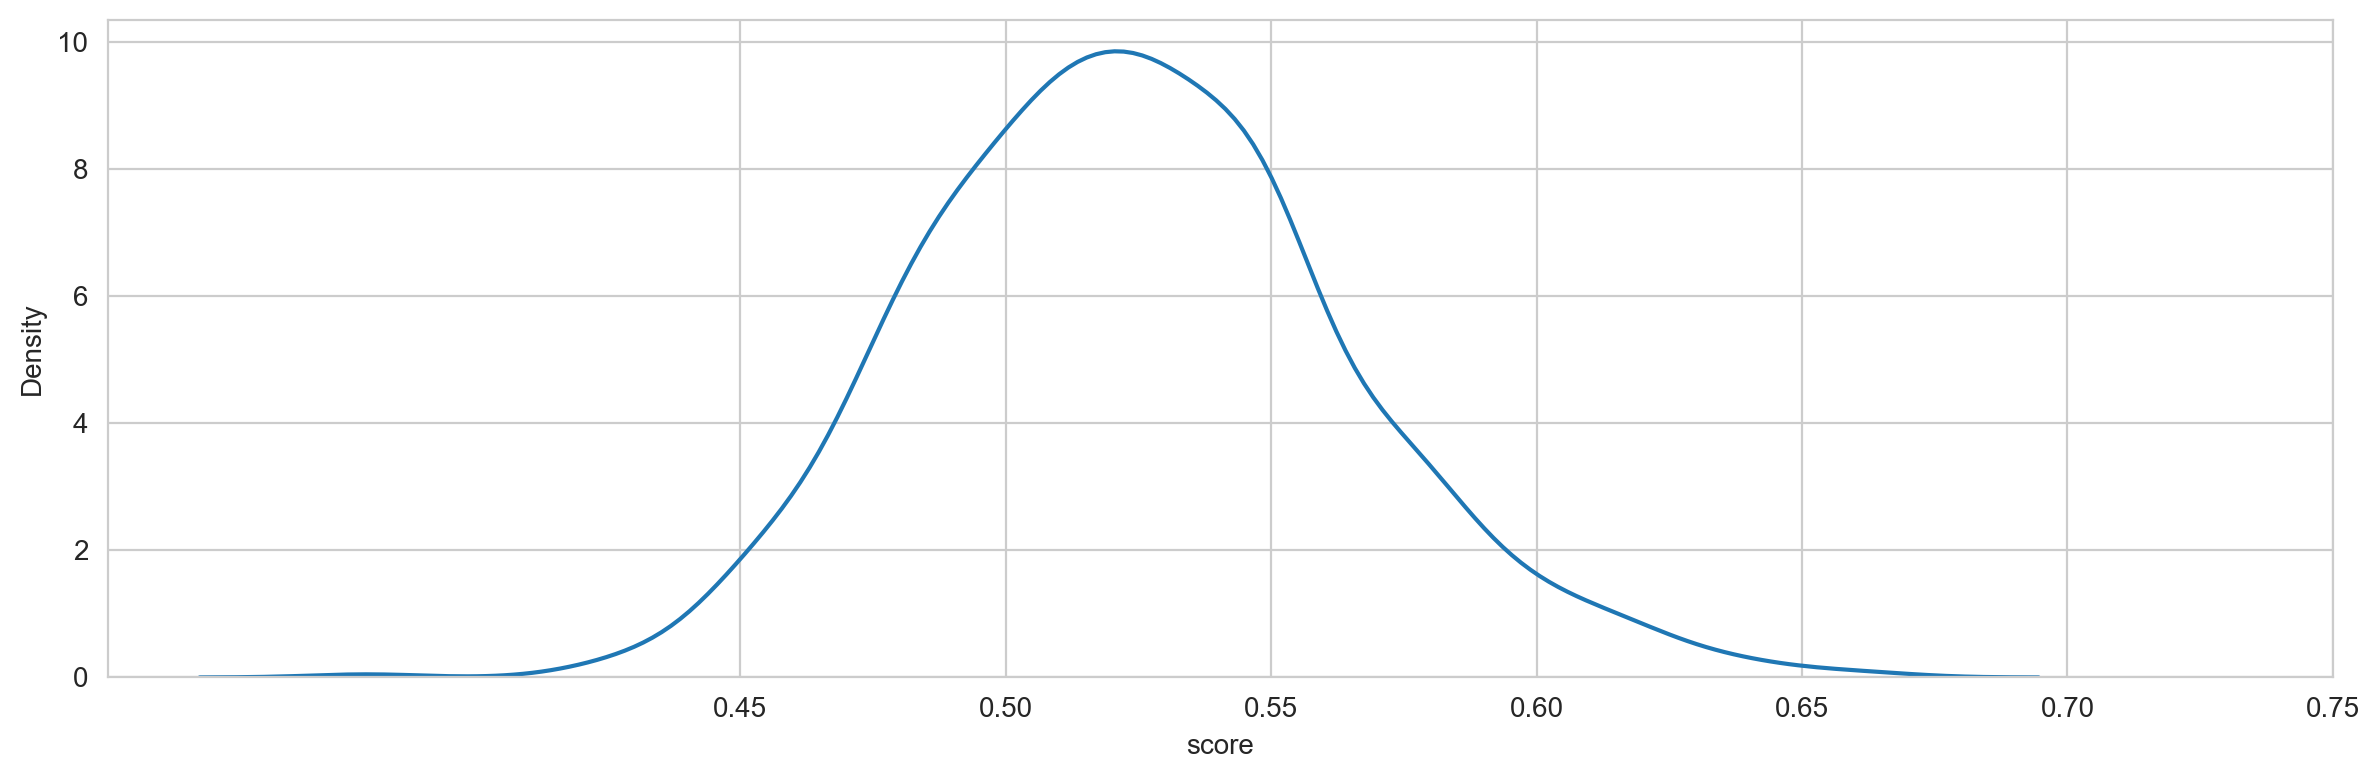

**Article 3**

The Reddit revolt: GameStop and the impact of social media on institutional investors

Following the explosive events surrounding GameStop in January, Annabel Smith unpacks the role of social media in this cautionary tale and its impact on institutional investors.

The Reddit revolution in the US has drawn attention to the potential power that a growing force of retail investors can wield in stock markets when equipped by social media.

Amateur investors have increasingly engaged with retail platforms in the last year, partly due to the pandemic leaving them idol at home, but also due to the newfound onslaught of information through social media and access to the market through retail brokerages and platforms such as Robinhood.

Set up in 2013 the mobile trading app, now valued at $21 billion and proclaimed to be democratising finance, offers investors access to the financial markets with zero commissions.

“For the largest online brokers, the number of daily trades has tripled since 2

**Top stocks**

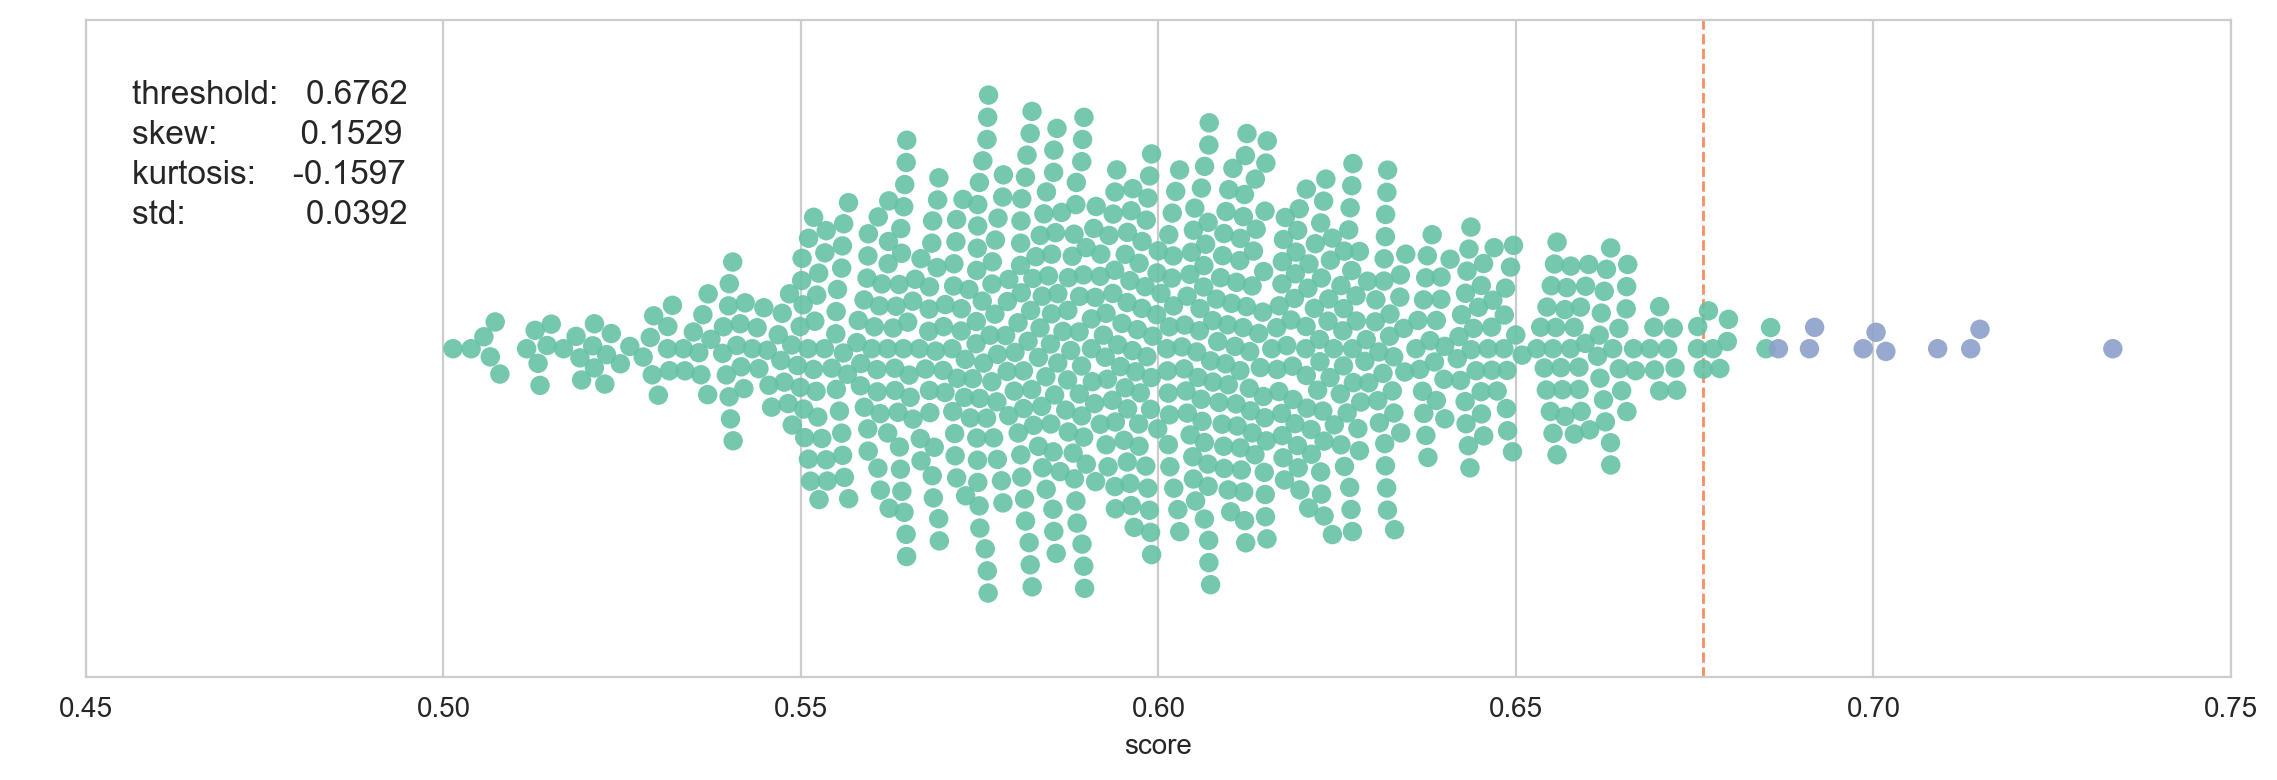

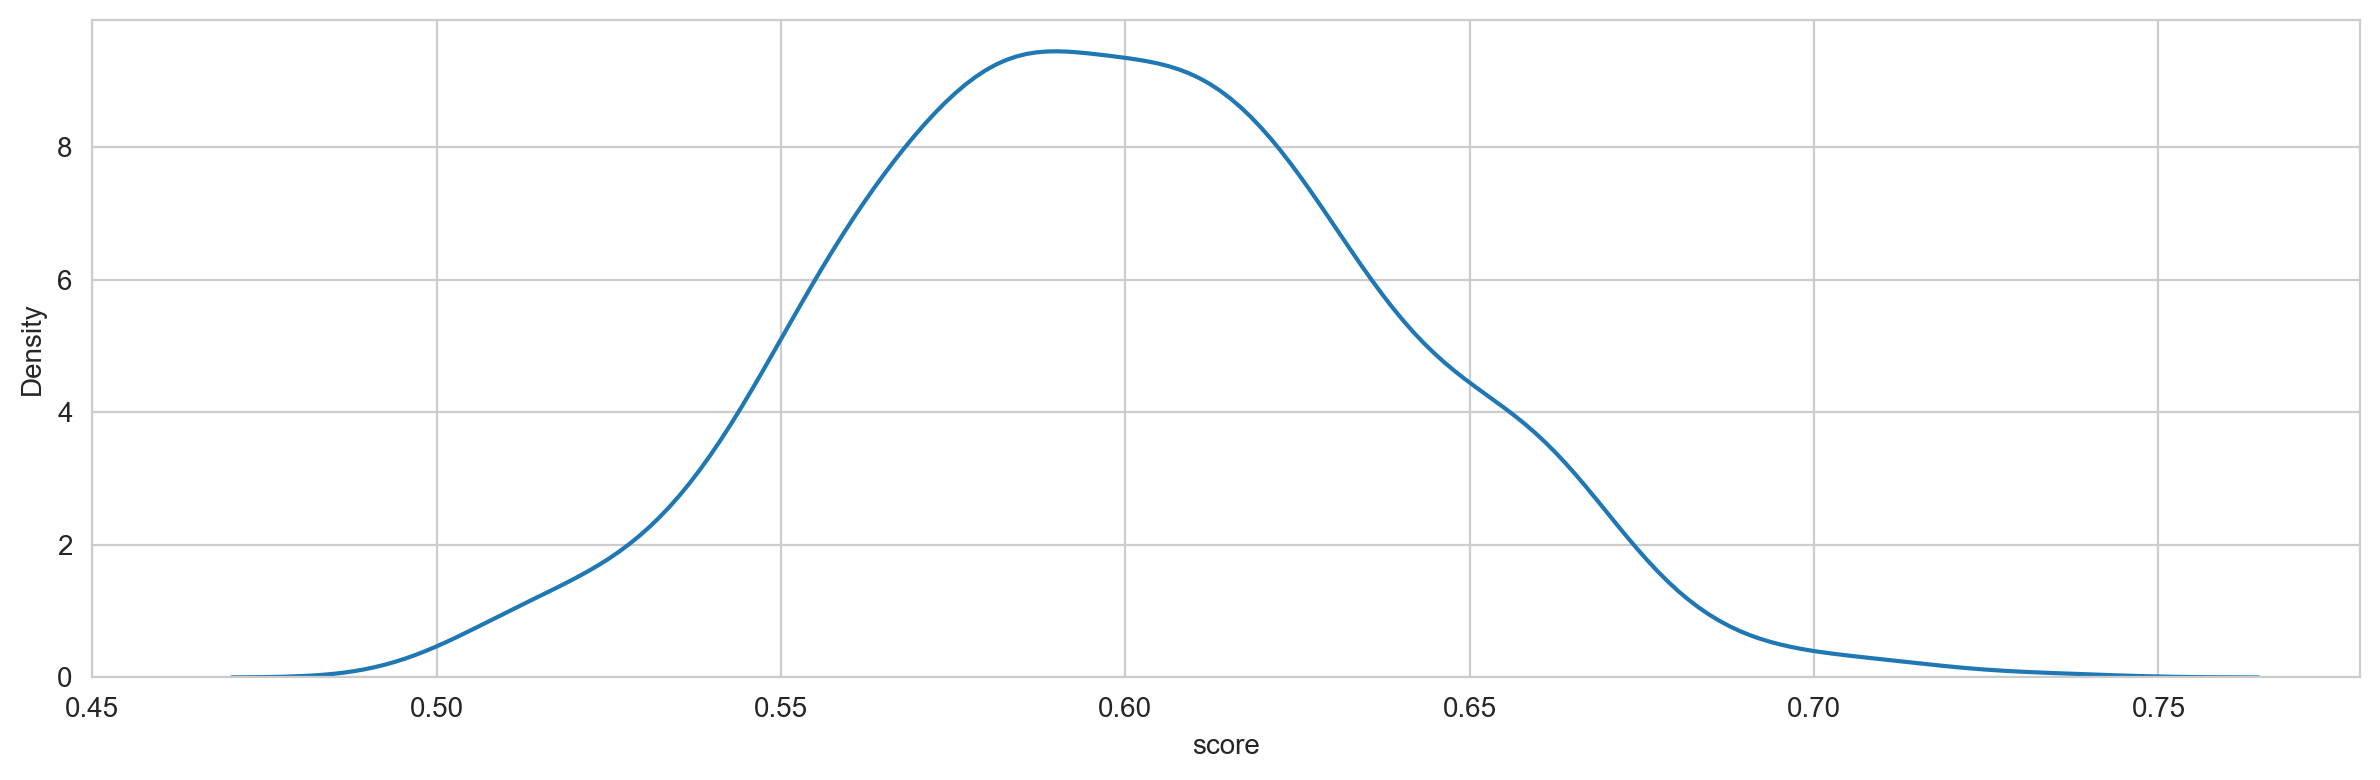

**Article 4**

Student loans: Expert explains what the government can do as pandemic pause ends

Student loan repayments are expected to restart at the end of January next year. 

But with one in five borrowers defaulting on their debt pre-pandemic, the government should tread carefully with at-risk borrowers, according to one expert.

"For people who struggle to repay afterwards for various reasons... we need to continue to have sort of what I think of as off-ramps — ways for those people to move out of repayments so that they aren't permanently stuck in debt that they'll never be able to repay," Kevin Miller, associate director of higher education at the Bipartisan Policy Center, said on Yahoo Finance Live (video above).

Outstanding student loan debt currently stands at $1.58 trillion as of the third quarter, which is a $14 billion rise from the previous ,according to the New York Fed.

About 5.3% of student loans were in serious delinquency or default, but since the government is reporting all fe

**Top stocks**

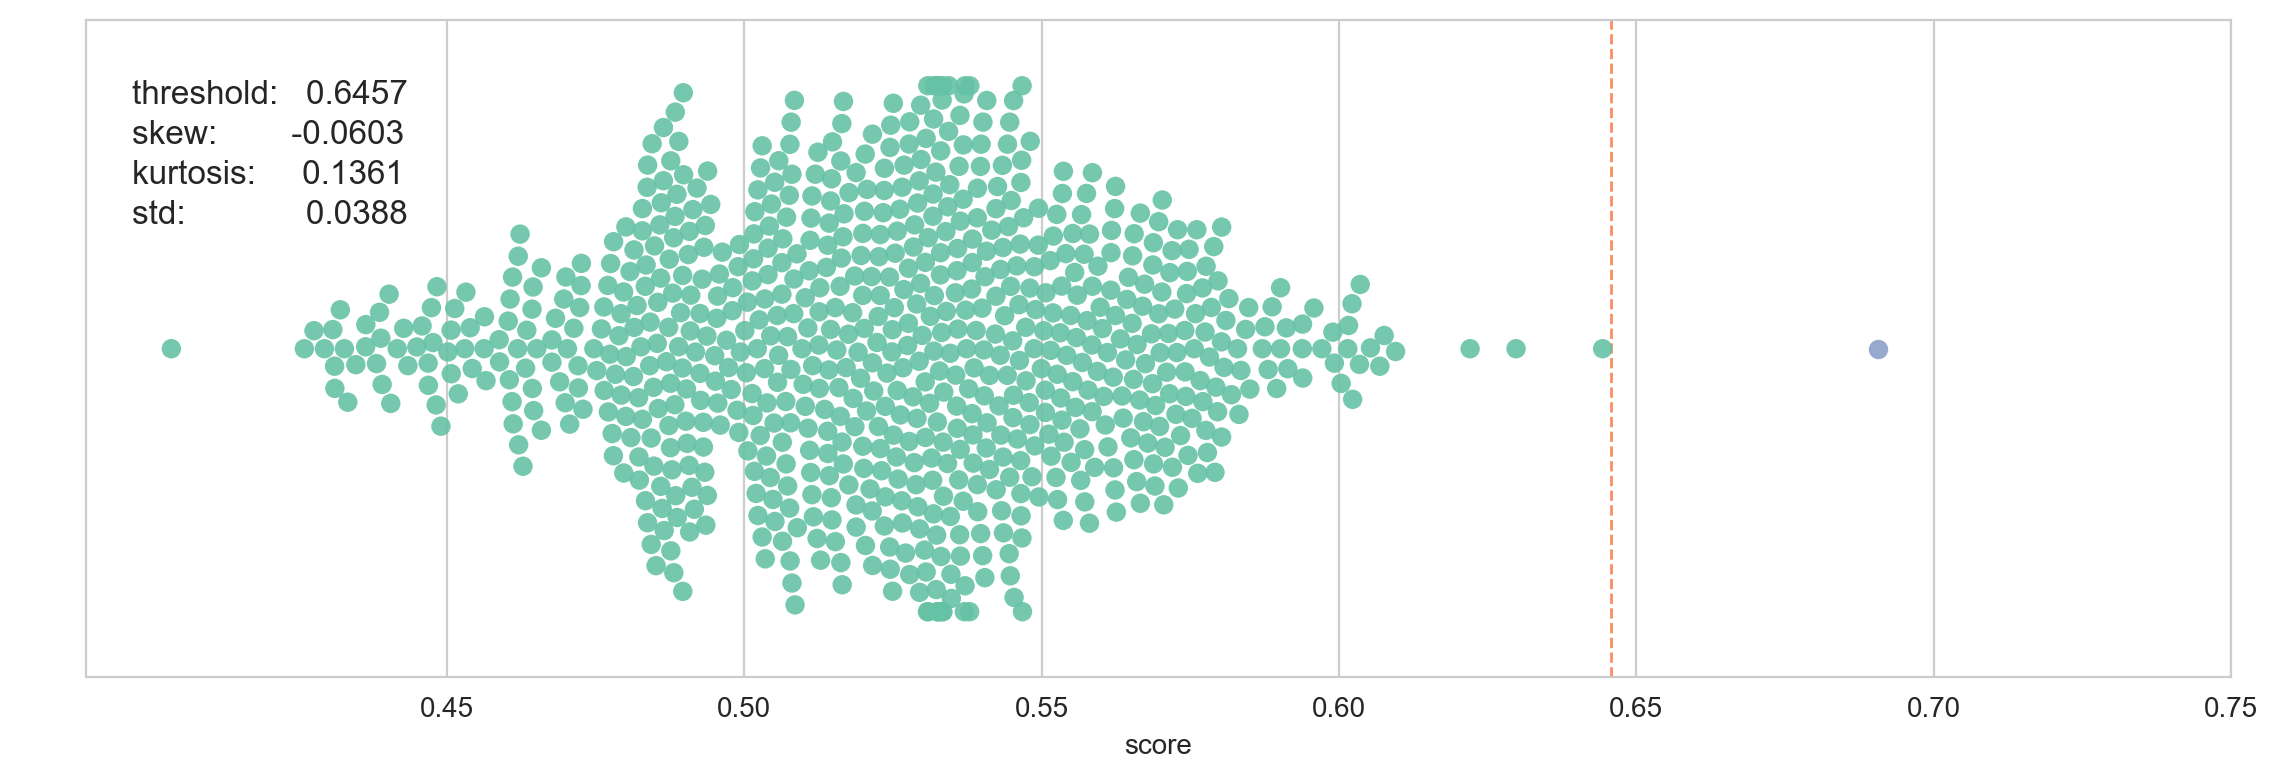

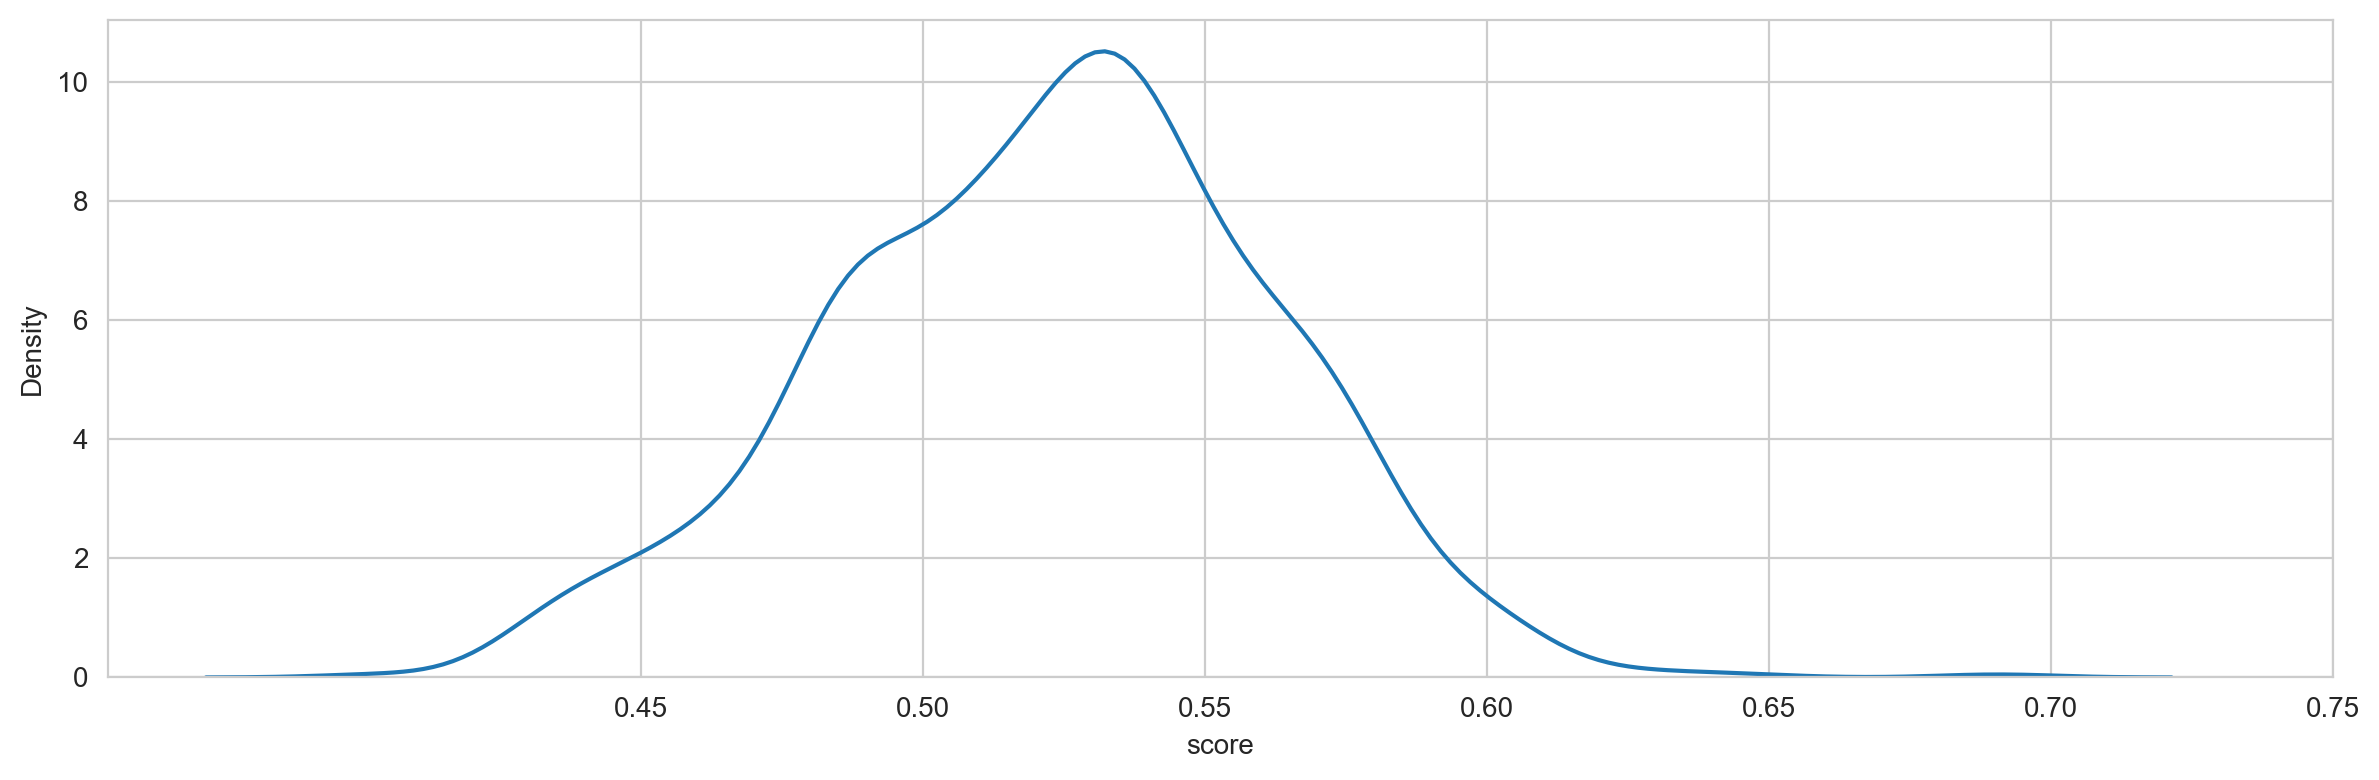

**Article 5**

COVID-19: What you need to know about the coronavirus pandemic on 10 November

1. How COVID-19 is affecting the globe

Confirmed cases of COVID-19 have passed 250.9 million globally, according to Johns Hopkins University. The number of confirmed deaths has now passed 5.06 million. More than 7.34 billion vaccination doses have been administered globally, according to Our World in Data.

The United States government is set to buy another $1 billion worth of the COVID-19 pill made by Merck and its partner Ridgeback Biotherapeutics, the companies announced yesterday.

AstraZeneca is creating a separate division for vaccines and antibody therapies, the drugmaker said on Tuesday, to focus on its COVID-19 shot and the development of coronavirus treatments.

Moderna has applied for European authorization of its COVID-19 vaccine in children aged 6-11 years, weeks after it delayed a similar filing in the United States.

Guinea will begin vaccinating children aged 12-17 against COVID-19 with a co

**Top stocks**

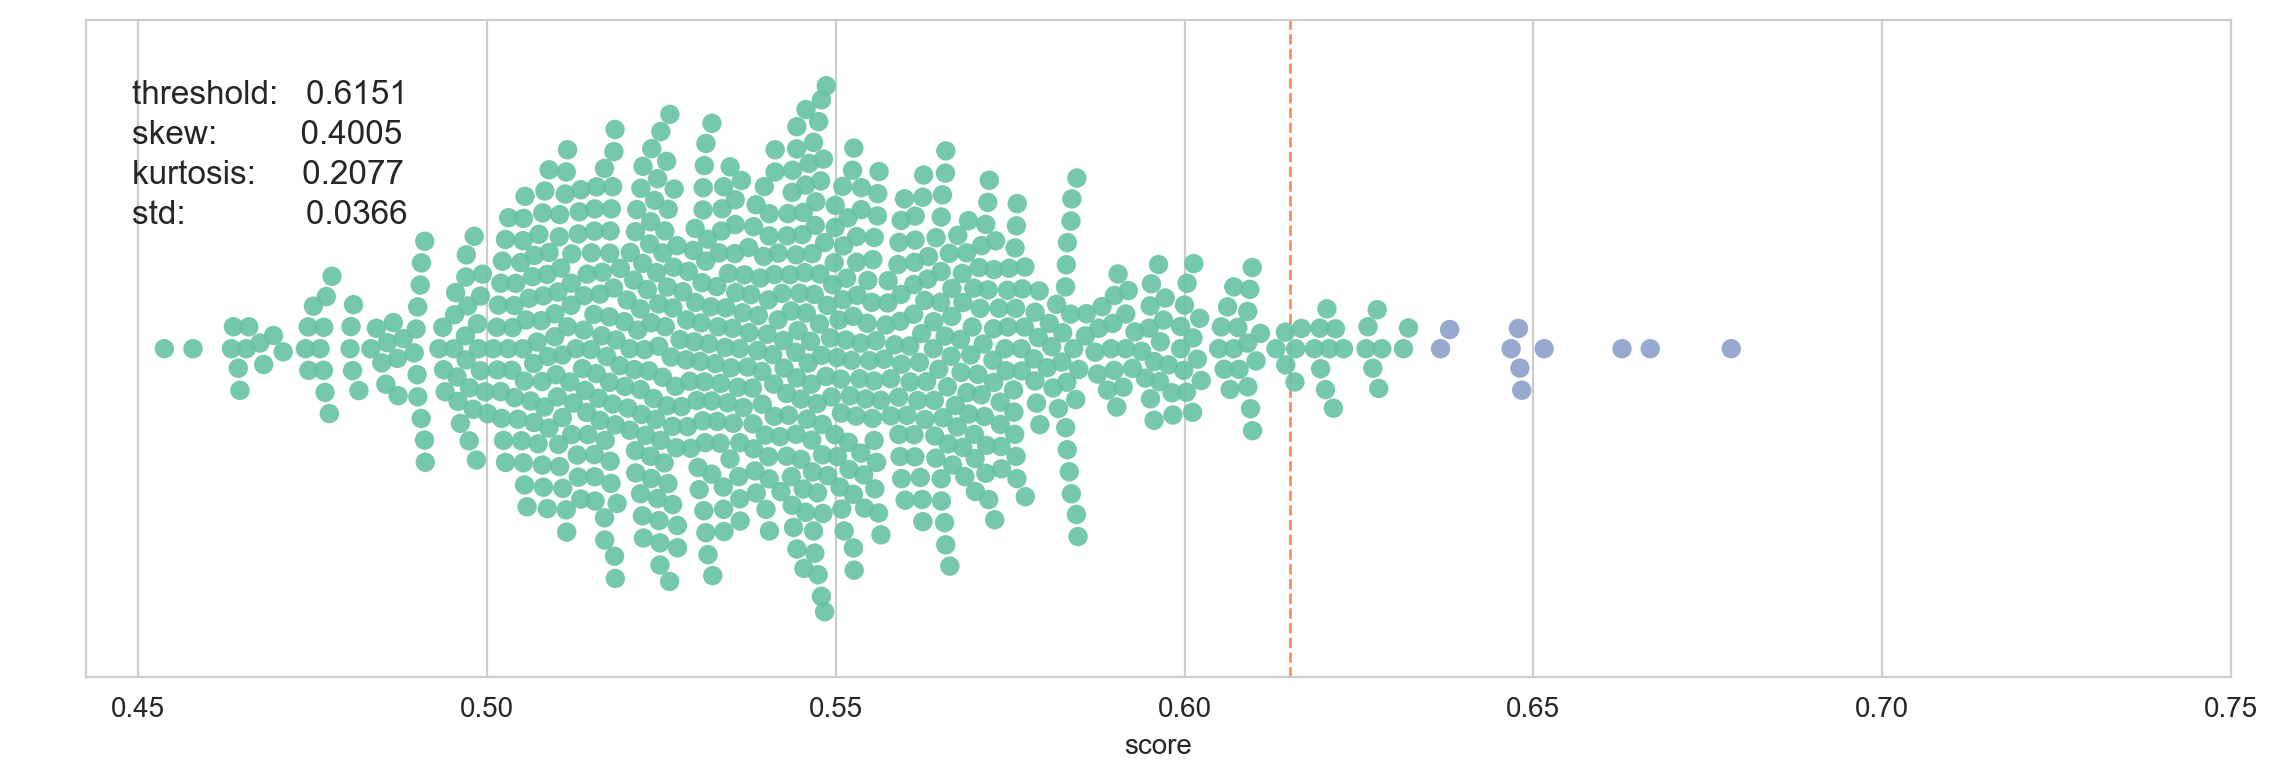

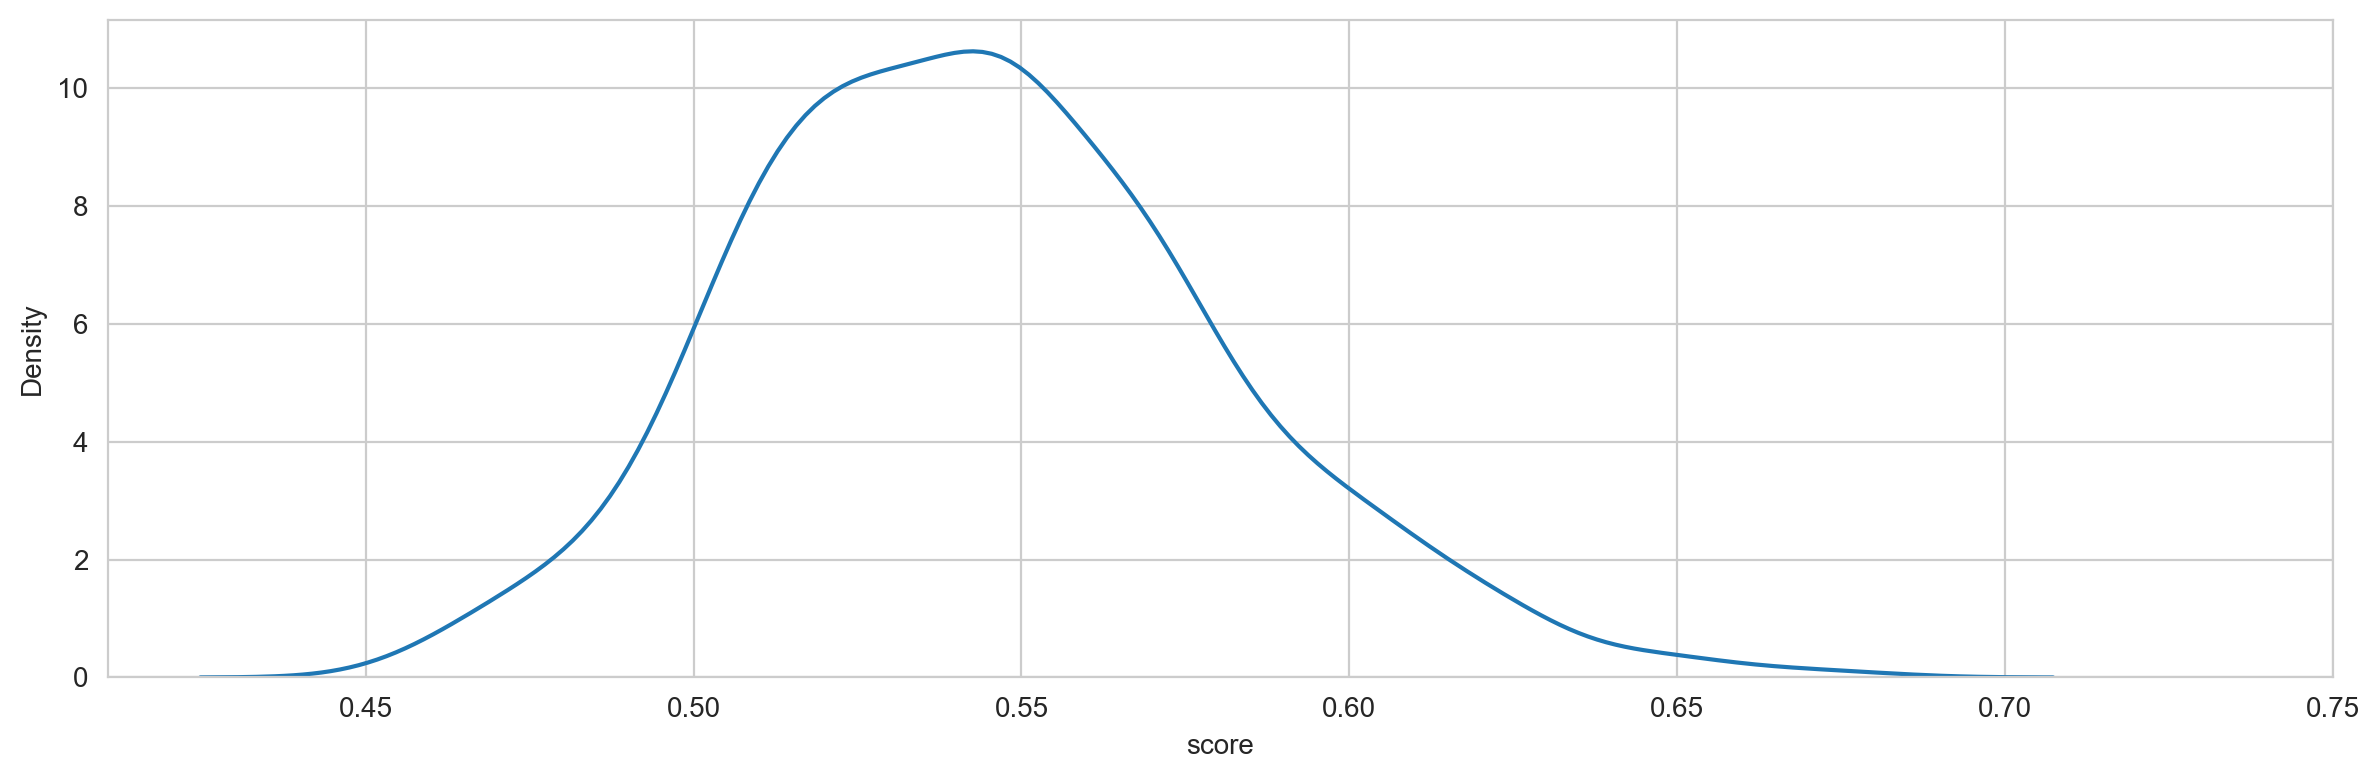

**Article 6**

When the Taliban Are in Your Bedroom

As armed Taliban inspected the New York Times bureau in Kabul, they were escorted by a journalist who used to be a U.S. Marine. The photo of him in uniform was plain for all to see, and ponder.

KABUL, Afghanistan — When the Taliban are in your bedroom and there’s a photograph of you on the wall holding an American flag, a rifle and dressed like a recruiting commercial for the Marines, you have to keep it together.

Then there’s the kitschy mug on your desk that you picked up from a shop just as Bagram Air Base closed in July. It reads, “Been there…done that/Operation Enduring Freedom.”

And the empty beer can in your trash that you drank the night before Kabul fell in August when you had a feeling this might be the last beer you drink in Afghanistan for awhile because the insurgents-turned-rulers don’t take kindly to booze.

And that photo of you in uniform? Taken just before the largest operation against the Taliban of the American war in Afghani

**Top stocks**

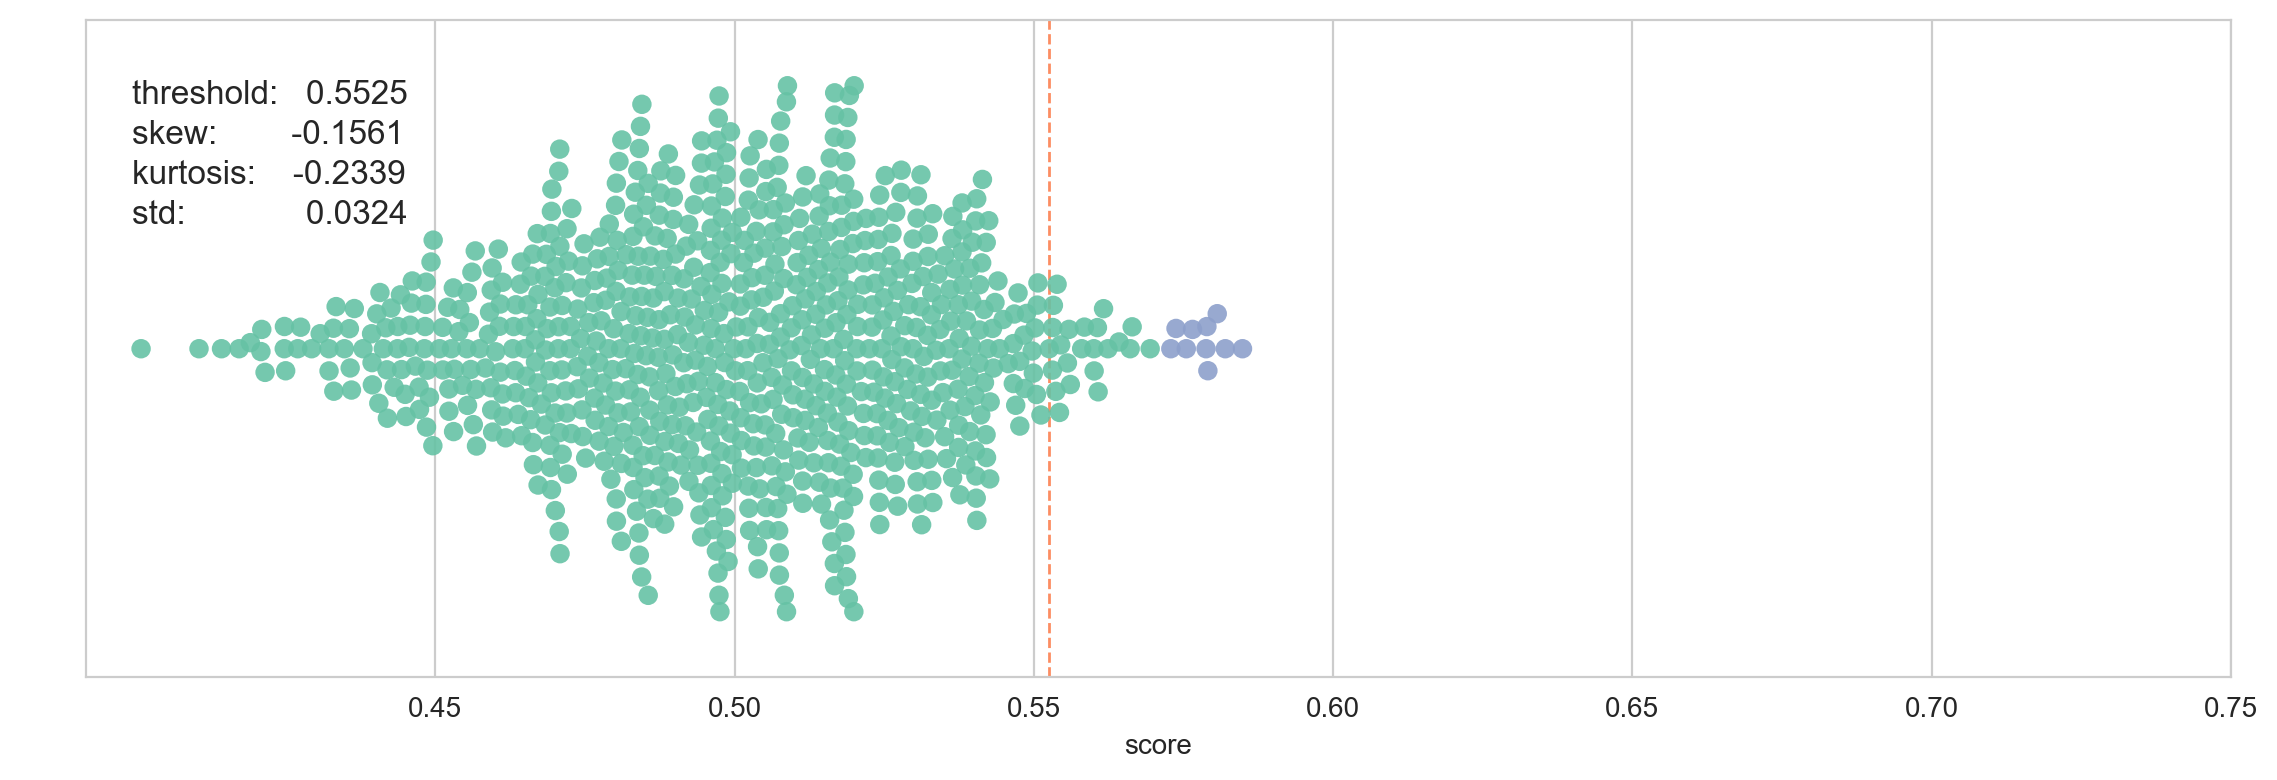

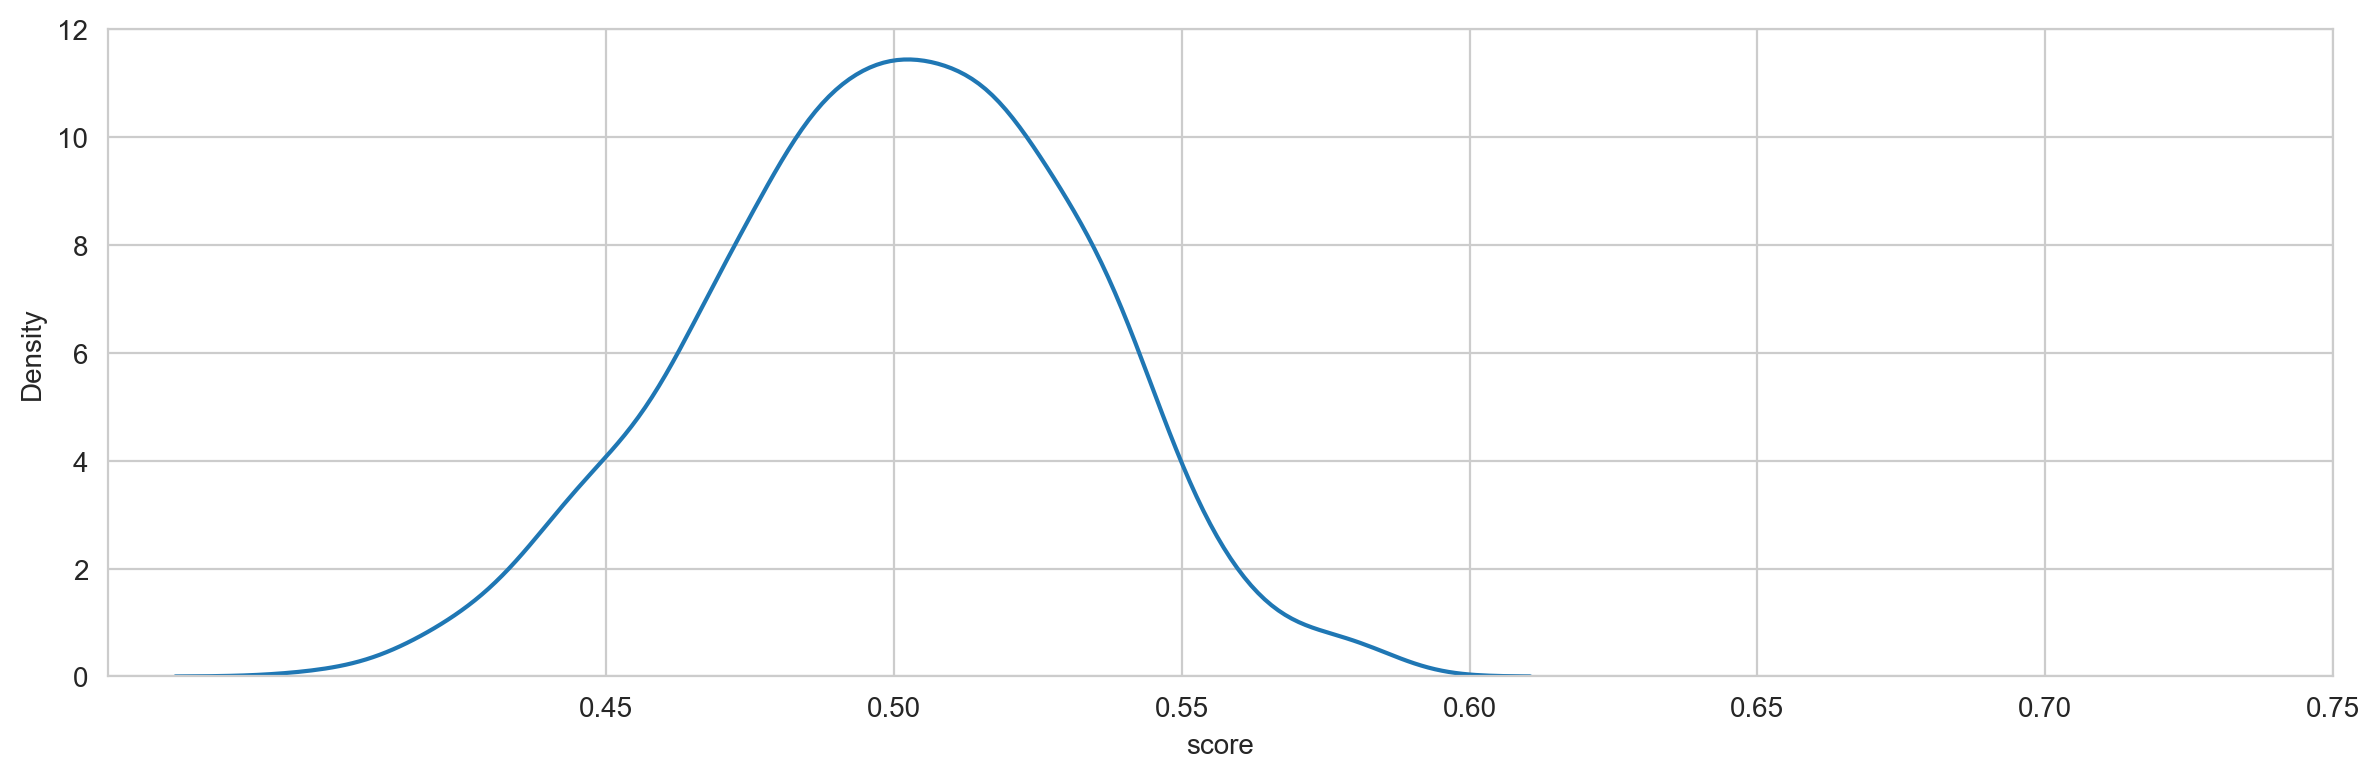

**Article 7**

Human space traveler No. 600 is launched into orbit

CAPE CANAVERAL, Fla. — A SpaceX rocket carried four astronauts toward orbit Wednesday night, including the 600th person to reach space in 60 years.

The repeatedly delayed flight occurred just two days after SpaceX brought four other astronauts home from the International Space Station. They should have been up there to welcome the newcomers, but NASA and SpaceX decided to switch the order based on Monday's ideal recovery weather in the Gulf of Mexico.

Germany's Matthias Maurer claimed the No. 600 position, according to NASA, based on his mission assignment. He and his three NASA crewmates should arrive at the space station in under 24 hours, well over a week late.

One of the astronauts — NASA isn't saying which one — was sidelined last week by an undisclosed medical issue. The crew member is fully recovered, according to NASA. Officials won't say whether it was an illness or injury, but noted it wasn't COVID-19.

Bad weather also 

**Top stocks**

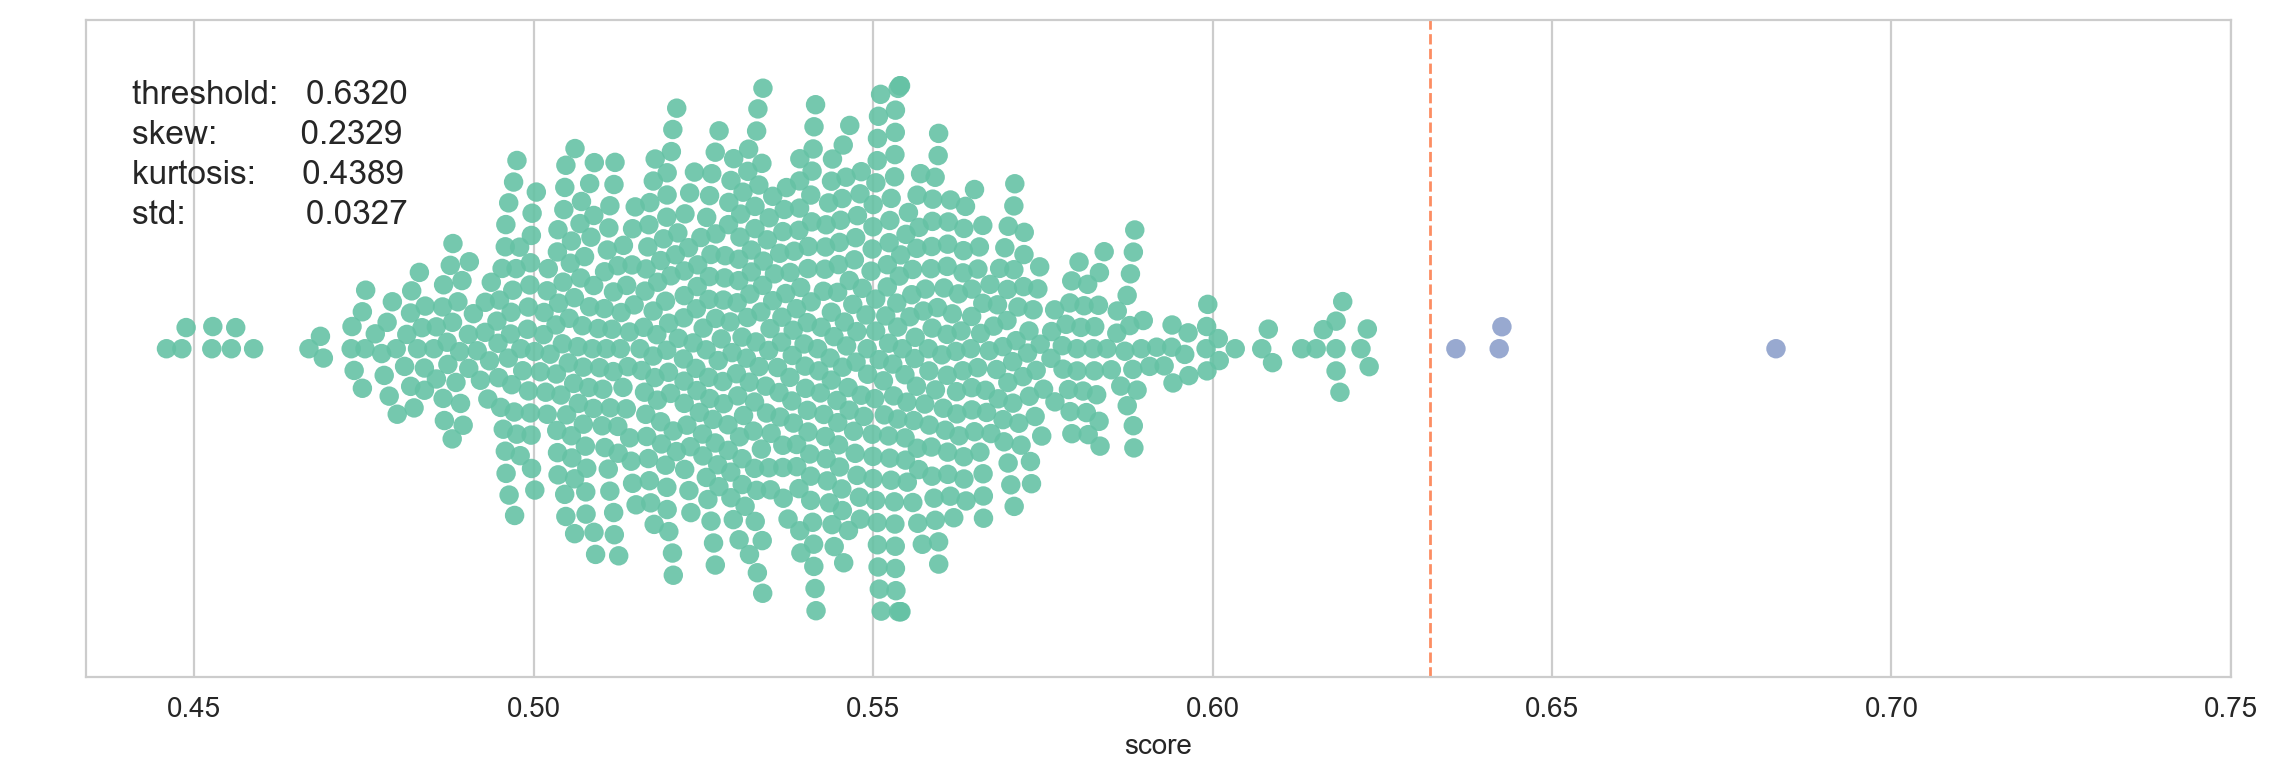

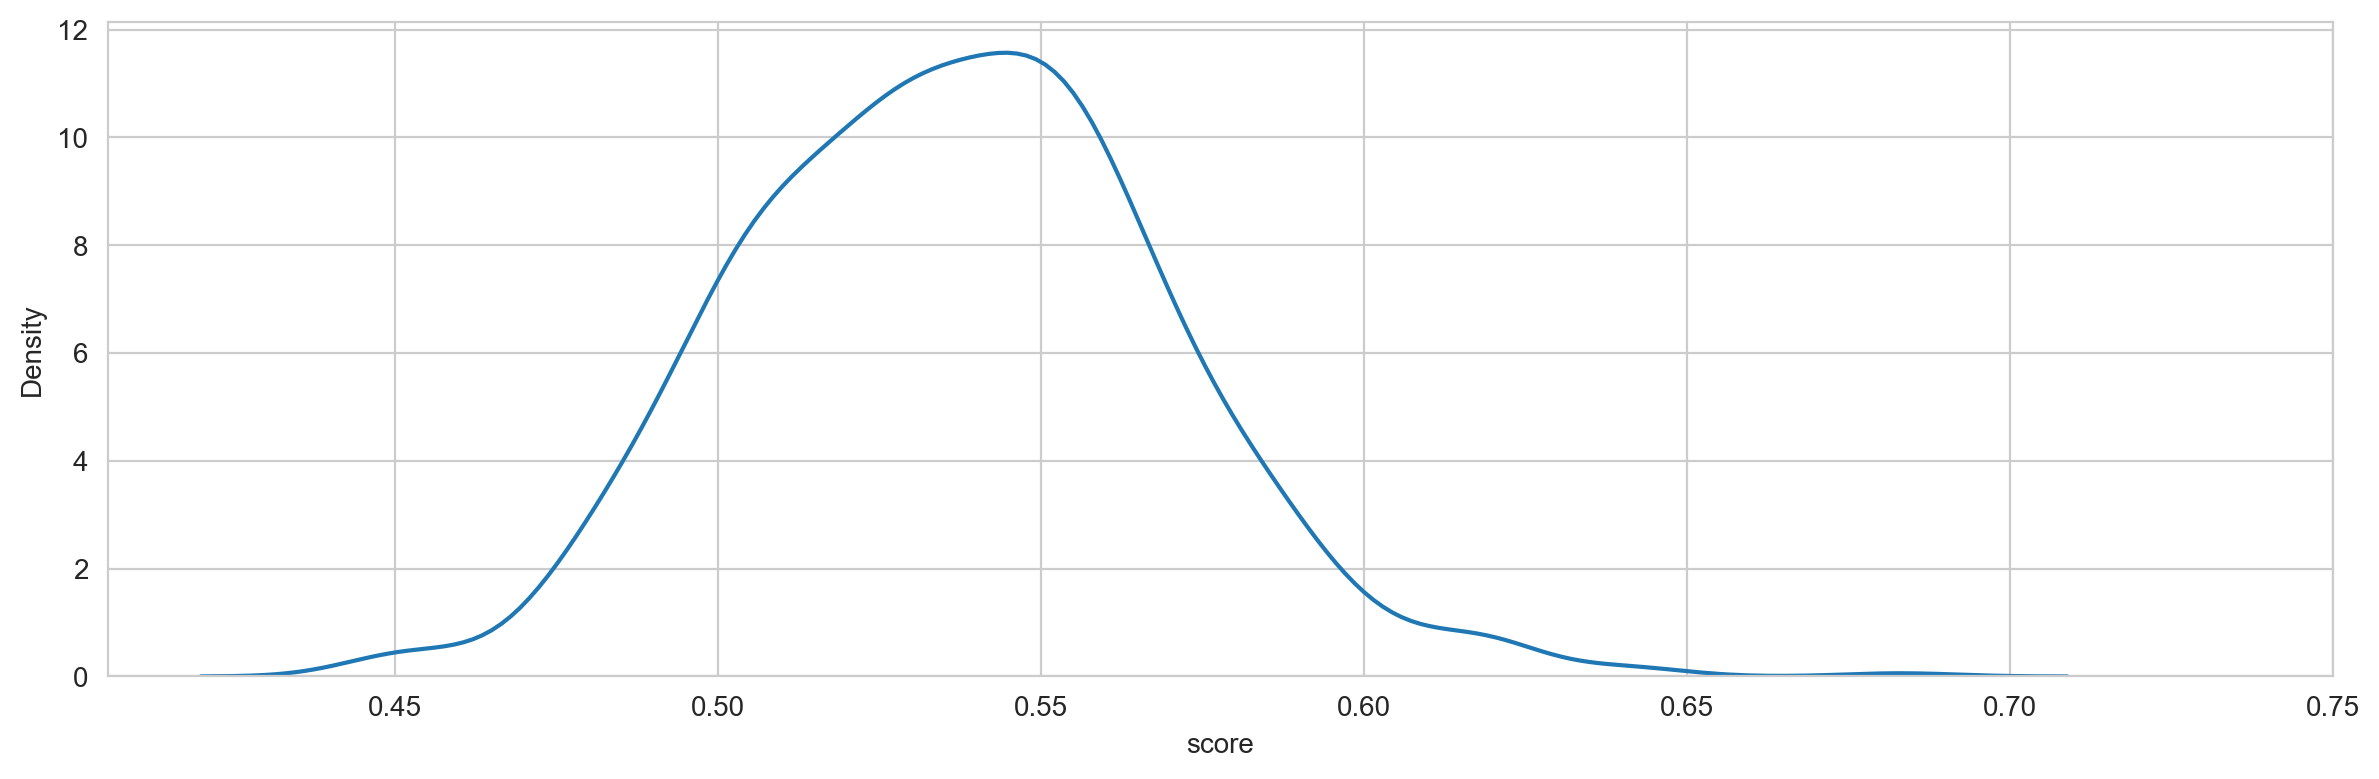

**Article 8**

How Fast Fashion Is Destroying the Planet

FASHIONOPOLIS

The Price of Fast Fashion and the Future of Clothes
By Dana Thomas

There is that old saying, usually attributed to Yves Saint Laurent: “Fashion fades, style is eternal.”

Literally speaking, that actually may no longer be true, especially when it comes to fast fashion. Fast-fashion brands may not design their clothing to last (and they don’t), but as artifacts of a particularly consumptive era, they might become an important part of the fossil record.

More than 60 percent of fabric fibers are now synthetics, derived from fossil fuels, so if and when our clothing ends up in a landfill (about 85 percent of textile waste in the United States goes to landfills or is incinerated), it will not decay.

Nor will the synthetic microfibers that end up in the sea, freshwater and elsewhere, including the deepest parts of the oceans and the highest glacier peaks. Future archaeologists may look at landfills taken over by nature and discover

**Top stocks**

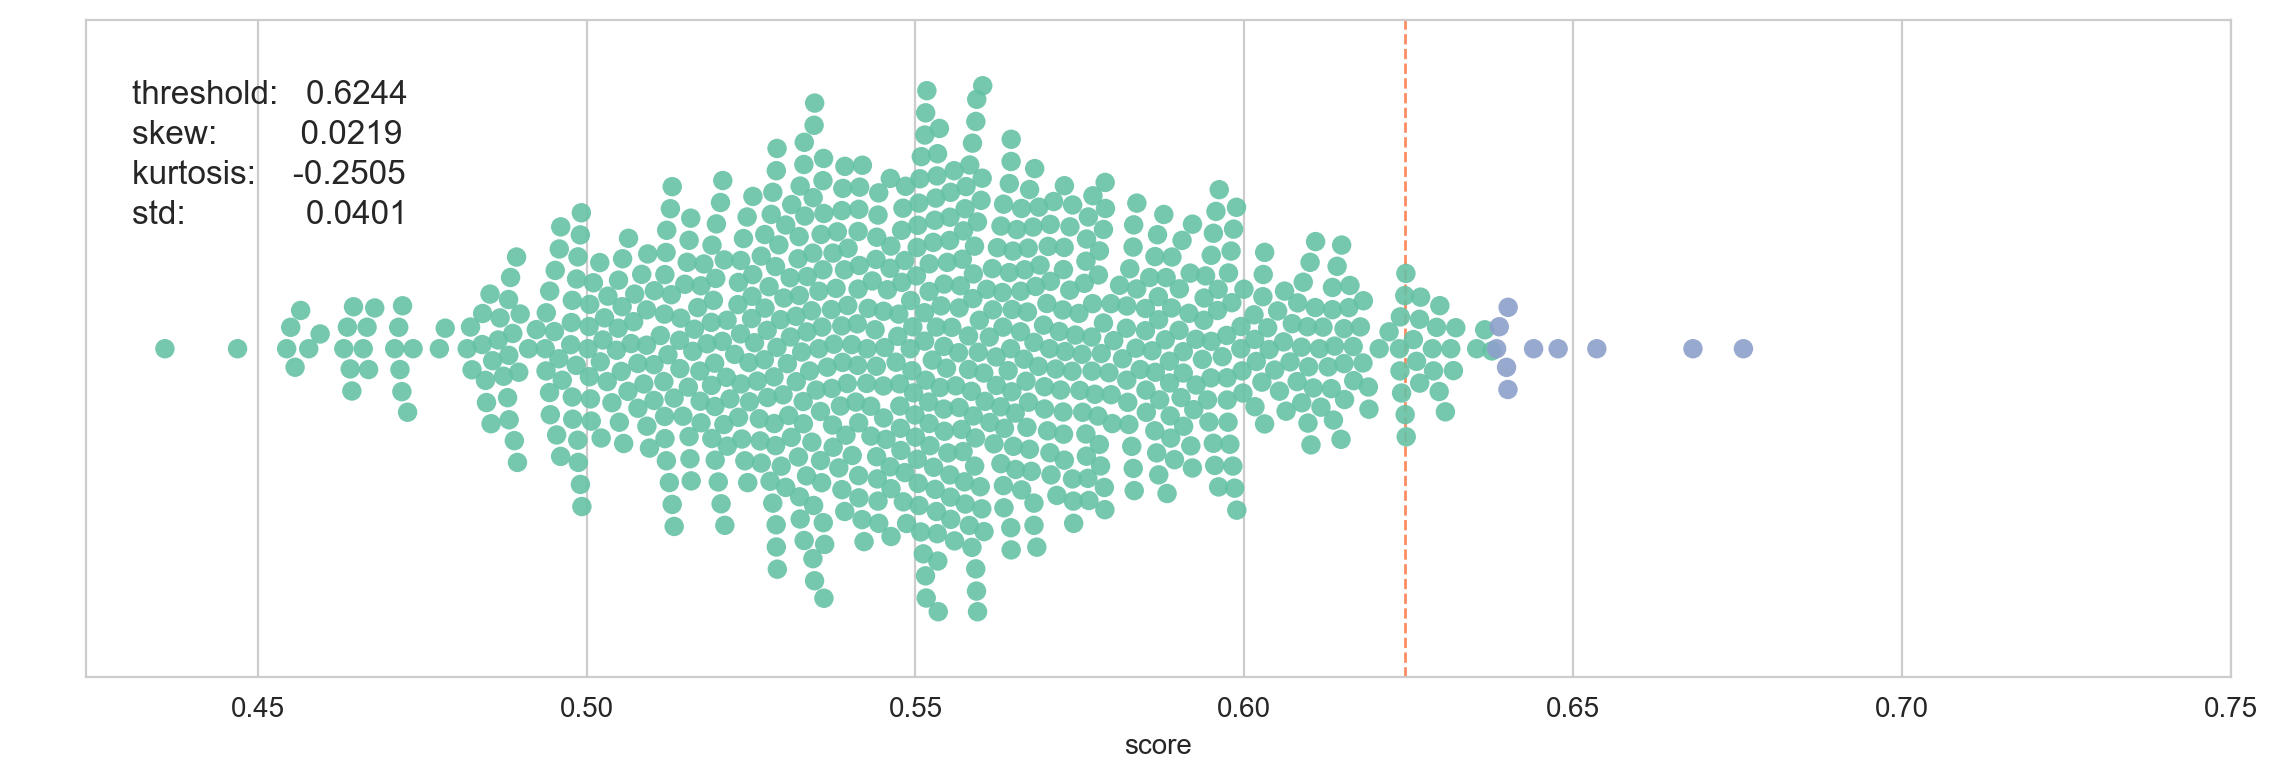

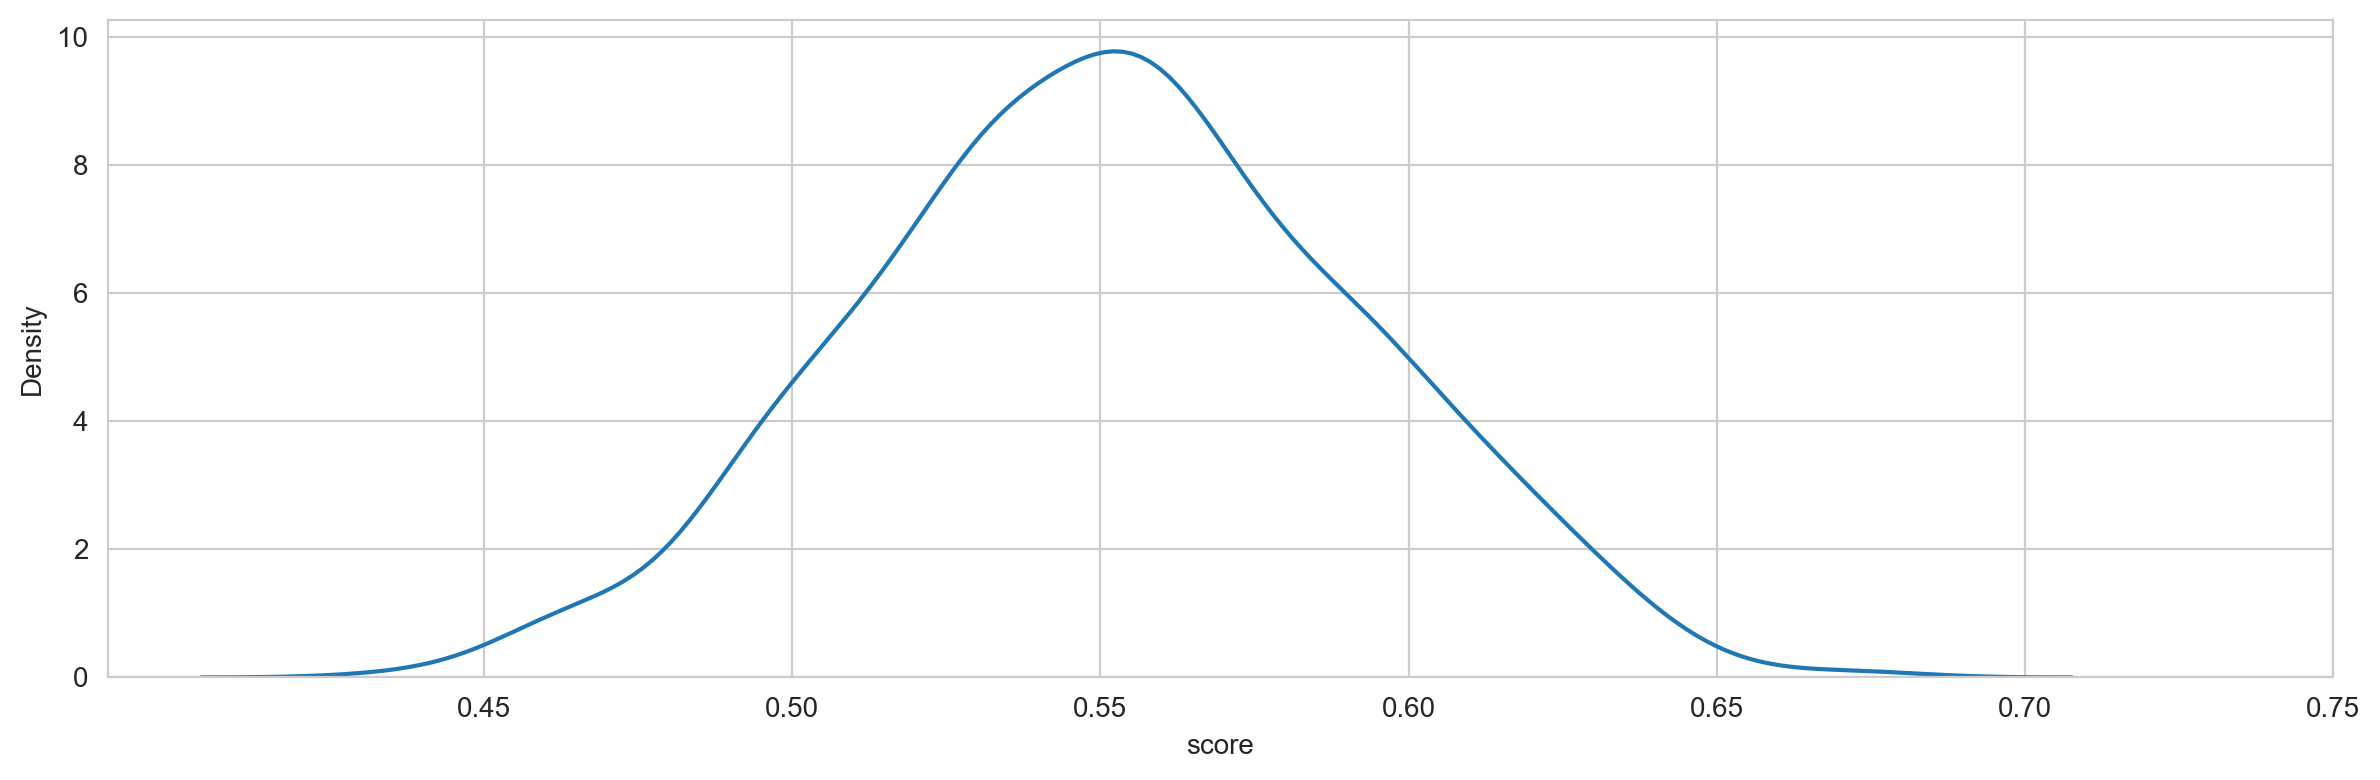

**Article 9**

The privacy paradox: we claim we care about our data, so why don’t our actions match?

Imagine how you’d feel if you discovered footage from your private home security camera had been broadcast over the internet. This is exactly what happened to several unsuspecting Australians last month, when the website Insecam streamed their personal lives online.

According to an ABC report, Insecam broadcasts live streams of dozens of Australian businesses and homes at any given time. Some cameras can be accessed because owners don’t secure them. Some may be hacked into despite being “secured”.

When asked if they care about their personal information being shared online, most people say they do. A 2017 survey found 69% of Australians were more concerned about their online privacy than in 2012.

However, a much smaller percentage of people actually take the necessary actions to preserve their privacy. This is referred to as the “privacy paradox”, a concept first studied about two decades ago.

To

**Top stocks**

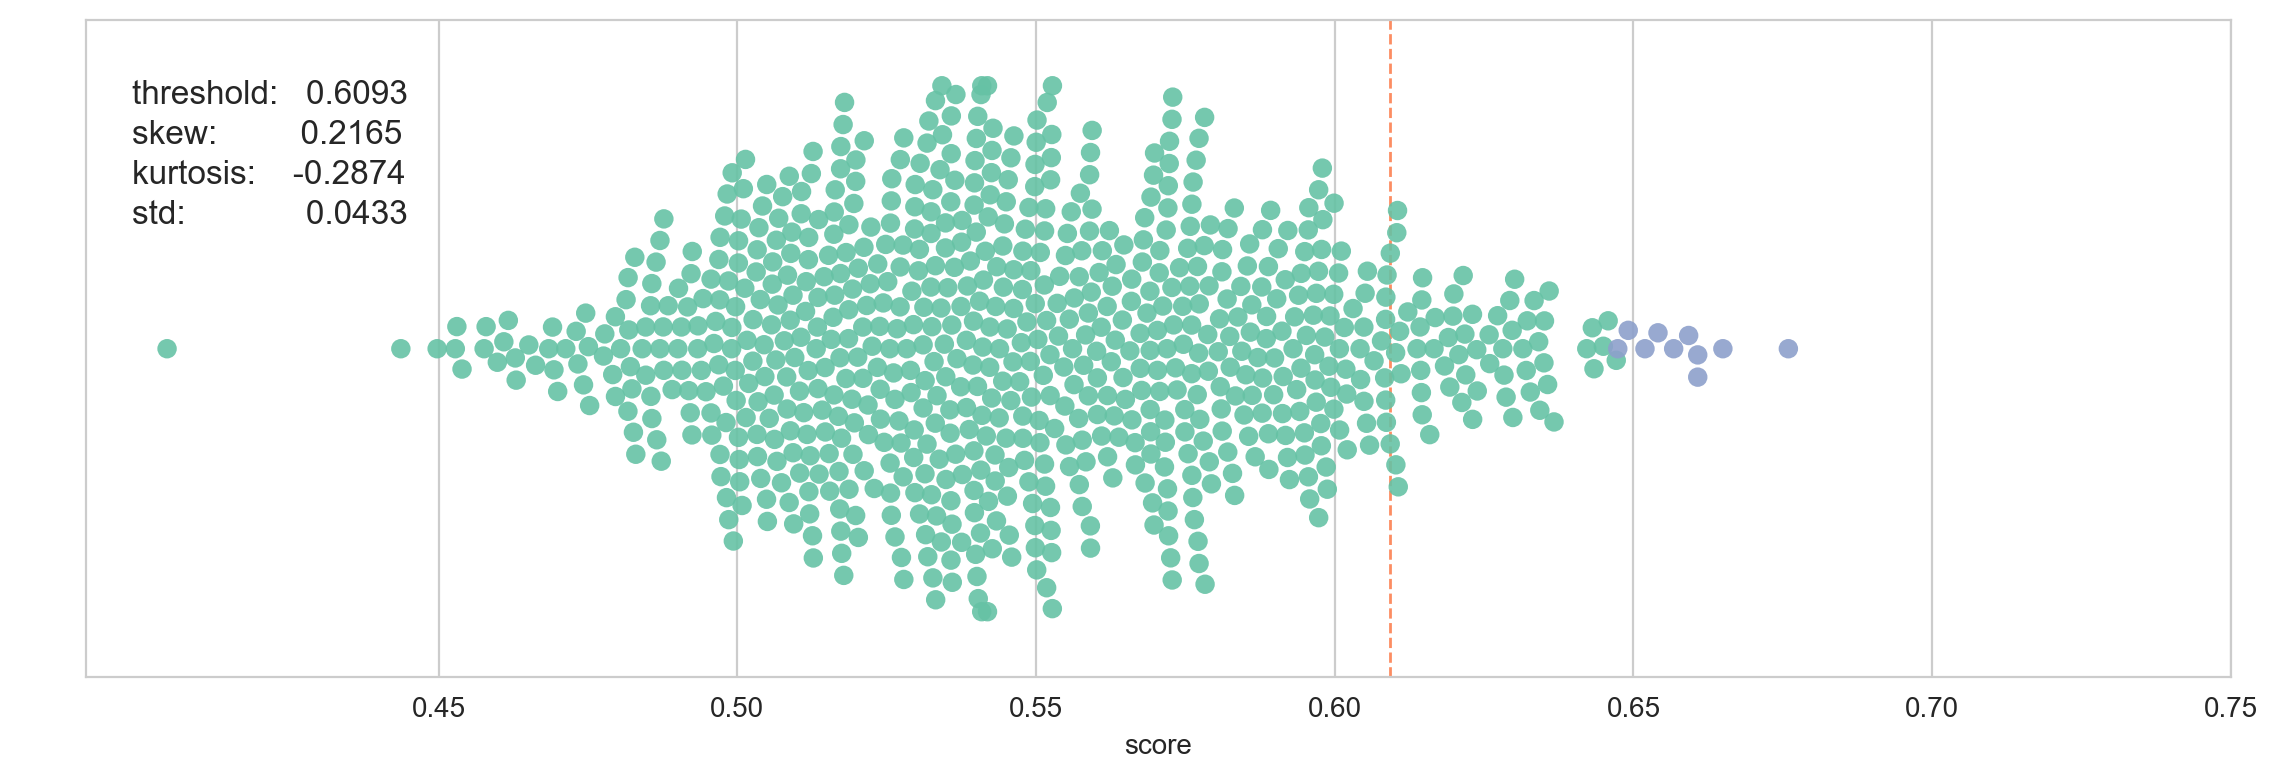

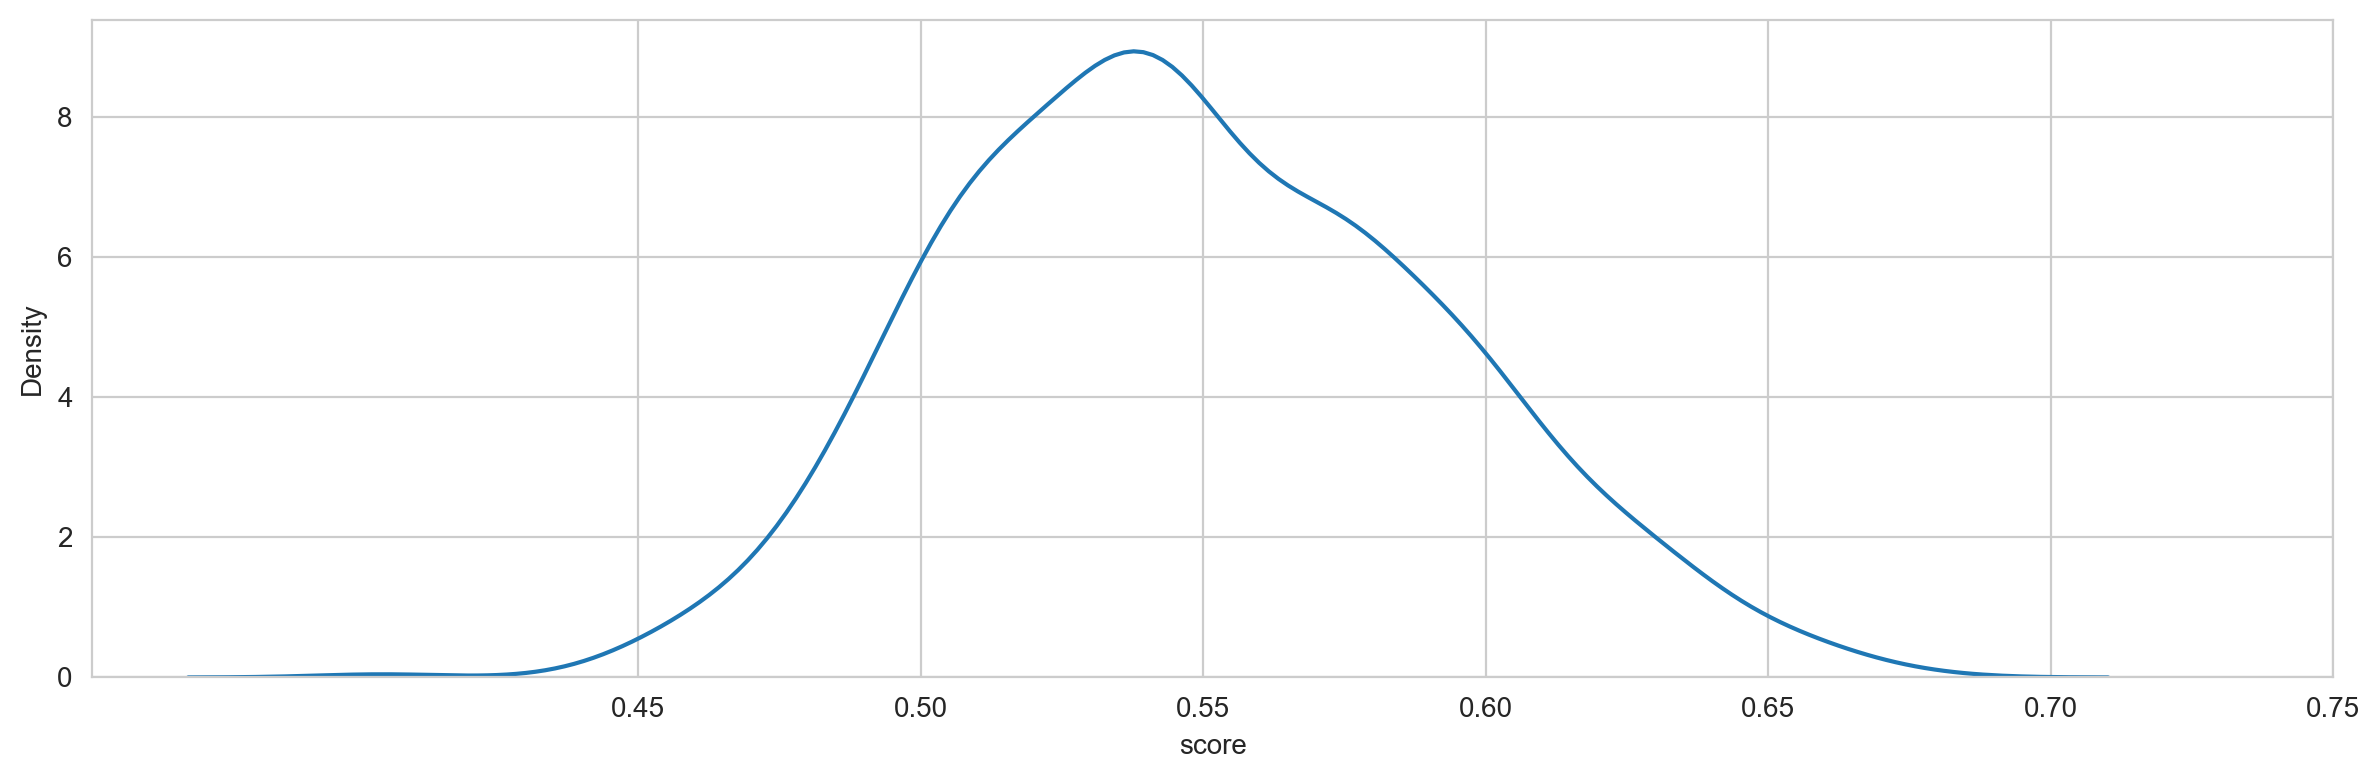

In [15]:
for article_id in range(len(articles)):
    _ = show_results(article_id, models=models, stocks_df=stocks_df, articles=articles)

### Saving article matches for user study 

In [22]:
output_path = Path("../../data/test/user_study/temp/article_matches_v1.validation.json")
output_path.parent.mkdir(exist_ok=True)

with open(output_path, "w") as fp:
    json.dump(article_matches, fp, ensure_ascii=False, indent="\t")

TypeError: Object of type DataFrame is not JSON serializable

### Displaying more results of articles noted in the evaluation document

In [19]:
def show_more_results(article_id, max_matches=15):
    stocks = show_results(article_id, max_matches=15)
    with pd.option_context("display.max_colwidth", None):
        print_strong("More results:")
        display(left_align_text(stocks.head(more)))

**Article 0**

Bezos’ Blue Origin loses NASA lawsuit over SpaceX $2.9 billion lunar lander contract

KEY POINTS

1. The U.S. Court of Federal Claims ruled against Jeff Bezos’ Blue Origin in the company’s lawsuit against NASA over a $2.9 billion lunar lander contract awarded to SpaceX.
2. Federal judge Richard Hertling sided with the defense in his ruling, completing a months-long battle.
3. A Blue Origin spokesperson said in a statement that the company’s lawsuit “highlighted the important safety issues with the Human Landing System procurement process that must still be addressed.”
4. Musk, in a tweet replying to CNBC’s report on the ruling, posted a photo from the 2012 movie “Dredd.”

The U.S. Court of Federal Claims ruled against Jeff Bezos’ Blue Origin on Thursday in the company’s lawsuit versus NASA over a lucrative astronaut lunar lander contract awarded to Elon Musk’s SpaceX earlier this year.

Federal Judge Richard Hertling sided with the defense in his ruling, completing a monthslong battle 

**Top stocks**

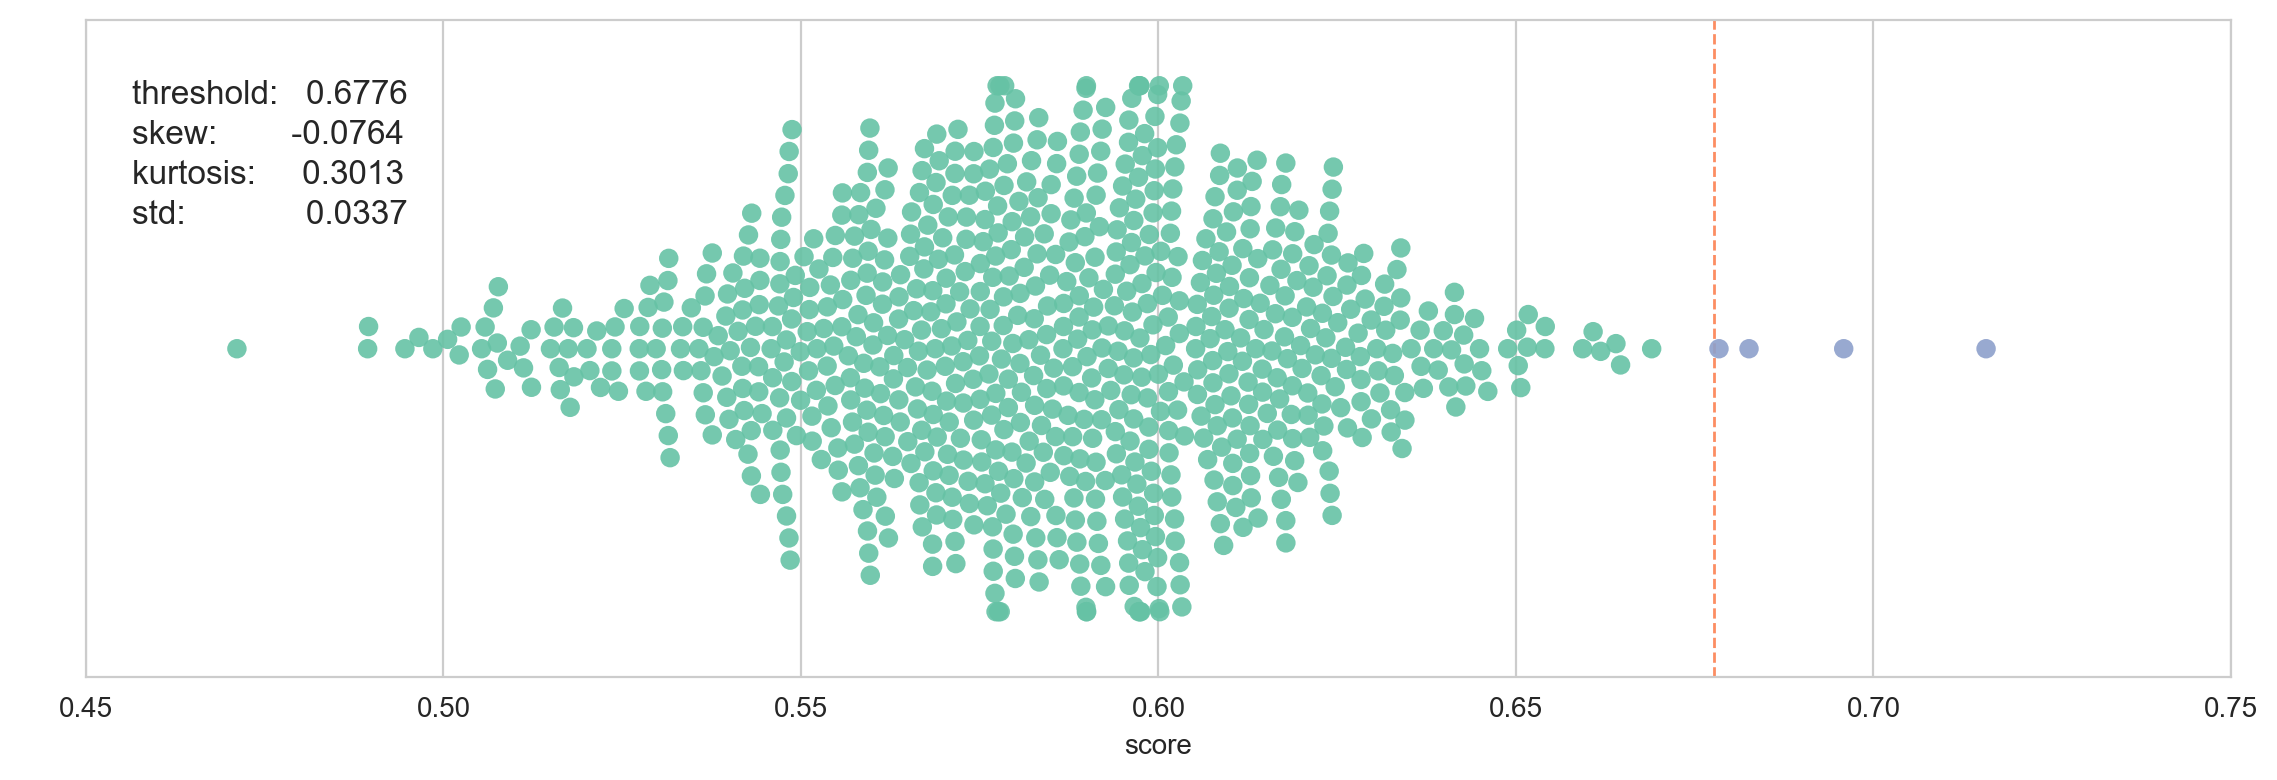

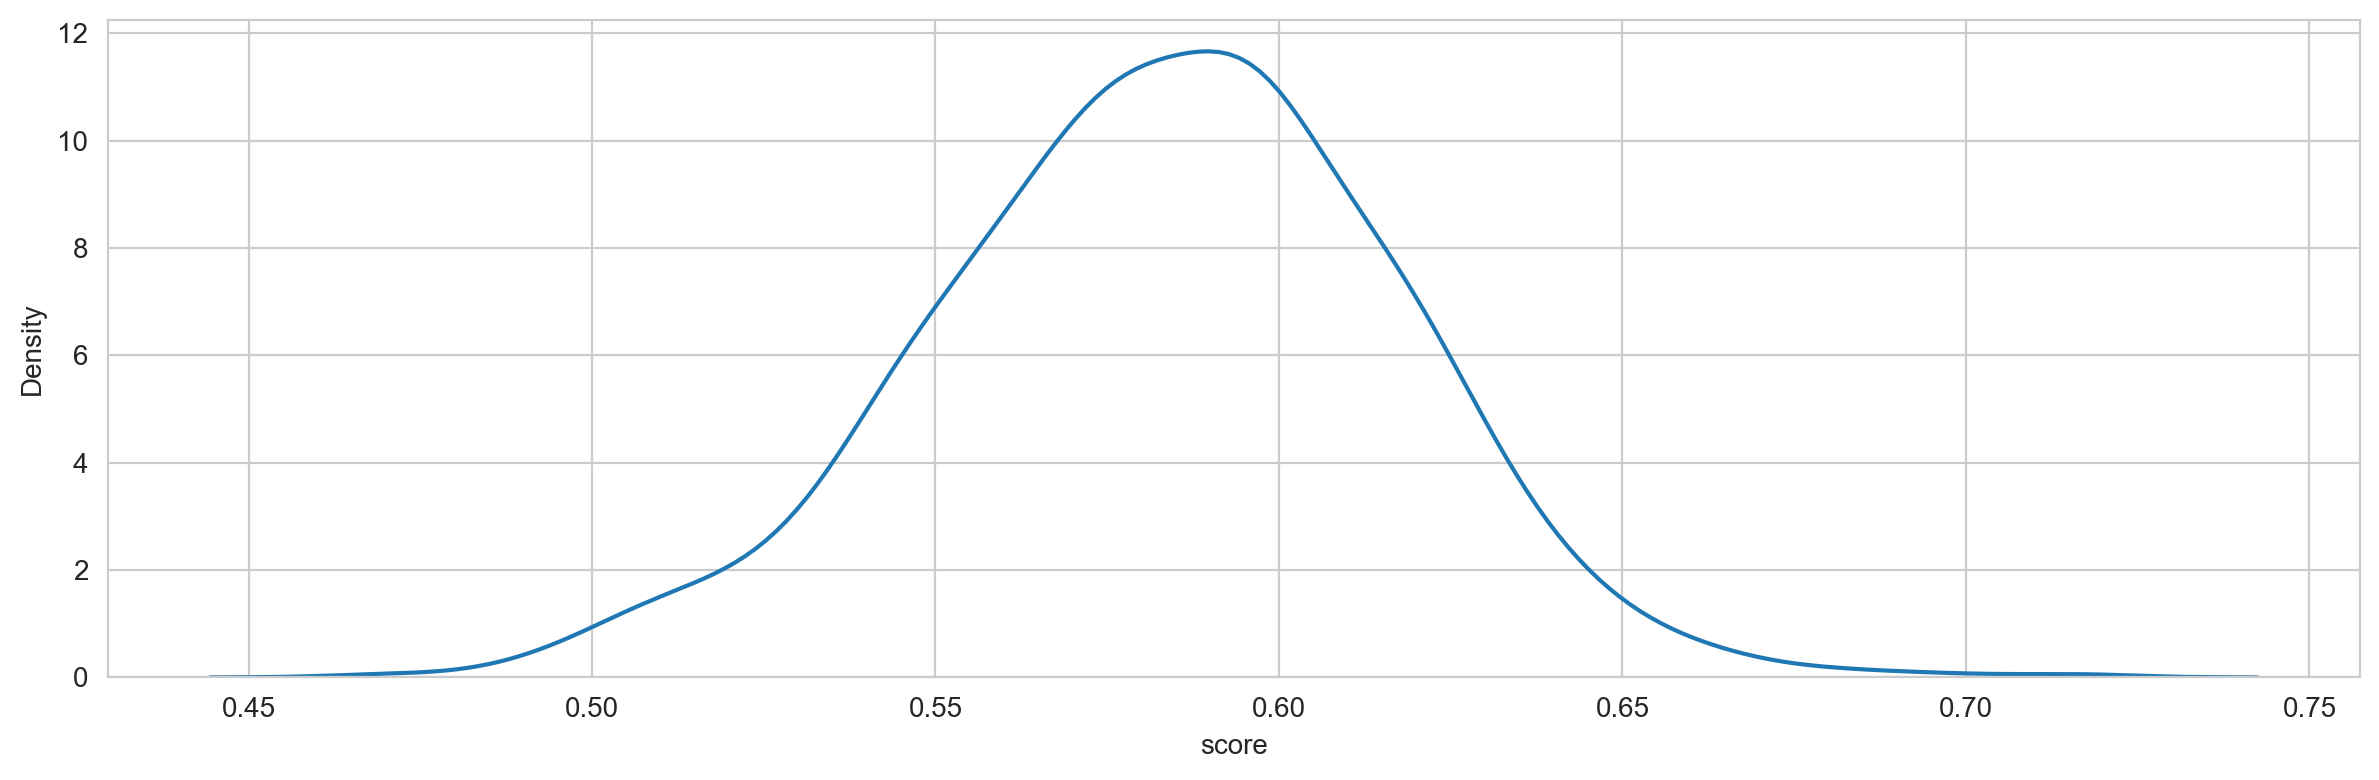

**More results:**

NameError: name 'more' is not defined

In [20]:
for article_id in range(10):
    show_more_results(article_id)